# Servicio Social 2024b-2025a
## Análisis NLP
### Cohesión en un equipo de trabajo

- Ignacio David Vázquez Pérez
- 20182928
- Ingeniería en computación
- ADRIANA PENA PEREZ NEGRON

### Features
- Lematización y Estematización: Procesar el texto para reducir las palabras a su forma base o raíz.
- Lectura de Palabras en su Raíz Origen: Extraer y analizar las palabras en su forma original.
- Gráfica de Palabras: Visualizar las palabras más comunes y su frecuencia en gráficos.
- Histograma NLP: Crear histogramas para mostrar la distribución de palabras y frases.
- Análisis de Sentimiento por Cada Pregunta: Evaluar el sentimiento de las respuestas para cada pregunta.
- Word Embedding: Analizar la relación y similitud entre palabras utilizando técnicas de incrustación de palabras.
- Agrupar por Años de Experiencia: Identificar tendencias y cohesión en base a los años de experiencia de los encuestados.
- Agrupar por Empresas: Evaluar los sentimientos en preguntas neutrales y determinar las palabras más utilizadas por los empleados de diferentes empresas.

In [1]:
import pandas as pd
import docx
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from spacy.lang.es.stop_words import STOP_WORDS
import matplotlib.pyplot as plt
from itertools import combinations, islice
import spacy
from wordcloud import WordCloud
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from textblob import TextBlob
import re


In [2]:
import spacy
from spacy.lang.es.stop_words import STOP_WORDS

nlp = spacy.load('es_core_news_sm')

In [3]:
class WordCloudGenerator:
    def __init__(self, df, text_columns):
        self.df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
        self.text_columns = text_columns

    def clean_text(self, text):
        # Remove common patterns (e.g., URLs, emails)
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'\S+@\S+', '', text, flags=re.MULTILINE)
        # Remove non-alphanumeric characters
        text = re.sub(r'\W', ' ', text)
        # Remove single characters
        text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
        # Remove multiple spaces
        text = re.sub(r'\s+', ' ', text, flags=re.I)
        # Convert to lowercase
        text = text.lower()
        return text

    def generate_word_cloud(self, text_data, column_name):
        # Remove stop words
        stop_words = set(STOP_WORDS)
        text_data = ' '.join([word for word in text_data.split() if word not in stop_words])
        # Generate word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)
        # Display the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for {column_name}')
        plt.show()

    def find_important_combinations(self, text_data, n):
        words = text_data.split()
        ngrams = zip(*[islice(words, i, None) for i in range(n)])
        ngram_counts = Counter(ngrams)
        most_common_ngrams = ngram_counts.most_common(3)
        return most_common_ngrams

    def run(self):
        for column in self.text_columns:
            text_data = ' '.join(self.df[column].apply(self.clean_text))
            self.generate_word_cloud(text_data, column)
            for n in range(1, 4):
                important_combinations = self.find_important_combinations(text_data, n)
                print(f'Most important {n}-word combinations for {column}: {important_combinations}')

In [4]:
import pandas as pd
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from textblob import TextBlob
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

class NLPAnalysis:
    def __init__(self, df, column_names, remove_sentiment_stop_words=True):
        self.df = df
        self.column_names = column_names
        self.nlp = spacy.load('en_core_web_sm')
        self.remove_sentiment_stop_words = remove_sentiment_stop_words
        
    def run(self):
        for column_name in self.column_names:
            self.analyze_factors(column_name)

    def analyze_factors(self, column_name):
        all_factors = ' '.join(self.df[column_name])
        all_factors = self.lemmatize_text(all_factors)

        vectorizer = CountVectorizer(stop_words=list(spacy.lang.es.stop_words.STOP_WORDS), ngram_range=(2, 5))
        X = vectorizer.fit_transform([all_factors])
        word_counts = X.toarray().sum(axis=0)
        words = vectorizer.get_feature_names_out()
        common_words = dict(zip(words, word_counts))

        tfidf_vectorizer = TfidfVectorizer(stop_words=list(spacy.lang.es.stop_words.STOP_WORDS), ngram_range=(2, 5))
        X_tfidf = tfidf_vectorizer.fit_transform([all_factors])
        tfidf_scores = X_tfidf.toarray().sum(axis=0)
        tfidf_words = tfidf_vectorizer.get_feature_names_out()
        important_words = dict(zip(tfidf_words, tfidf_scores))

        common_words = {self.normalize_ngram(k): v for k, v in common_words.items() if self.normalize_ngram(k)}
        important_words = {self.normalize_ngram(k): v for k, v in important_words.items() if self.normalize_ngram(k)}
        combined_ngrams = {**common_words, **important_words}
        most_common_ngrams = Counter(combined_ngrams).most_common(10)
        common_factors = [word for word, count in most_common_ngrams]

        self.plot_common_words(most_common_ngrams, column_name)
        self.plot_wordcloud(all_factors, column_name)
        self.word_embedding(all_factors, column_name)

    def lemmatize_text(self, text):
        doc = self.nlp(text)
        if self.remove_sentiment_stop_words:
            return ' '.join([token.lemma_ for token in doc if not token.is_stop])
        else:
            return ' '.join([token.lemma_ for token in doc])

    def normalize_ngram(self, ngram):
        words = ngram.split()
        lemmatized_words = [self.lemmatize_text(word) for word in words]
        if len(lemmatized_words) != len(set(lemmatized_words)):
            return None
        # Preserve the original order of words
        return ' '.join(lemmatized_words)

    def plot_common_words(self, most_common_words, column_name):
        common_words_df = pd.DataFrame(most_common_words, columns=['phrase', 'count'])
        plt.figure(figsize=(12, 6), dpi=600)
        plt.bar(common_words_df['phrase'], common_words_df['count'], color='skyblue')
        plt.xlabel('Phrases')
        plt.ylabel('Count')
        plt.title(f'Most Common Phrases in {column_name}')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    def plot_important_words(self, most_important_words, column_name):
        important_words_df = pd.DataFrame(most_important_words, columns=['phrase', 'score'])
        plt.figure(figsize=(12, 6), dpi=600)
        plt.bar(important_words_df['phrase'], important_words_df['score'], color='lightgreen')
        plt.xlabel('Phrases')
        plt.ylabel('TF-IDF Score')
        plt.title(f'Most Important Phrases in {column_name}')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    def generate_word_cloud(self, text_data, column_name):
        stop_words = set(spacy.lang.es.stop_words.STOP_WORDS)
        words = [word for word in text_data.split() if word not in stop_words]
        lemmatized_words = [self.lemmatize_text(word) for word in words]
        unique_words = list(set(lemmatized_words))
        text_data = ' '.join(unique_words)
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for {column_name}')
        plt.show()

    def find_important_combinations(self, text_data, n):
        words = text_data.split()
        ngrams = zip(*[islice(words, i, None) for i in range(n)])
        ngram_counts = Counter(ngrams)
        most_common_ngrams = ngram_counts.most_common(3)
        return most_common_ngrams
        
    def plot_wordcloud(self, all_factors, column_name):
        all_factors = self.clean_text(all_factors)
        self.generate_word_cloud(all_factors, column_name)
        for n in range(1, 4):
            important_combinations = self.find_important_combinations(all_factors, n)
            normalized_combinations = [self.normalize_ngram(' '.join(map(str, comb))) for comb in important_combinations]
            unique_combinations = list(filter(None, set(normalized_combinations)))
            print(f'Most important {n}-word combinations for {column_name}: {unique_combinations}')
        
    def clean_text(self, text):
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'\S+@\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'\W', ' ', text)
        text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
        text = re.sub(r'\s+', ' ', text, flags=re.I)
        text = text.lower()
        return text

    def word_embedding(self, text, column_name, save_plot=False, plot_path='word_embedding.png'):
        vectorizer = TfidfVectorizer(stop_words=list(spacy.lang.es.stop_words.STOP_WORDS))
        X = vectorizer.fit_transform([text])
        words = vectorizer.get_feature_names_out()
        word_vectors = X.toarray().T
        if word_vectors.shape[0] < 2 or word_vectors.shape[1] < 2:
            print(f"Not enough samples or features for word embedding in {column_name}")
            return

        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(word_vectors)
        tsne = TSNE(n_components=2)
        tsne_result = tsne.fit_transform(word_vectors)
        umap_result = umap.UMAP(n_components=2).fit_transform(word_vectors)

        plt.figure(figsize=(18, 6), dpi=300)

        plt.subplot(1, 3, 1)
        plt.scatter(pca_result[:, 0], pca_result[:, 1], c='red', label='PCA')
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        plt.title(f'PCA Word Embedding for {column_name}')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c='blue', label='t-SNE')
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        plt.title(f't-SNE Word Embedding for {column_name}')
        plt.legend()

        plt.subplot(1, 3, 3)
        plt.scatter(umap_result[:, 0], umap_result[:, 1], c='green', label='UMAP')
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        plt.title(f'UMAP Word Embedding for {column_name}')
        plt.legend()

        plt.suptitle(f'Word Embedding for {column_name}', fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])

        plt.show()

In [5]:
# Read a CSV file with headers set to True
df = pd.read_excel('audios_escritos.xlsx', header=0)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [6]:
df

Nombre  \
0   RAMSES EMMANUEL VAZQUEZ GALINDO   
1   JOSE ANTONIO CARDENAS CASTAÑEDA   
2            ALEJANDRO CHAVEZ GOMEZ   
3        ANDRE RAFAEL LOZA ARECHIGA   
4                  DAVID CANTO CRUZ   
..                              ...   
71  ULISES OLDEMAR ORTEGA GUTIERREZ   
72      BRYAN DANIEL NUÑEZ ALVARADO   
73  ELIUD ALEJANDRO MUÑOZ ESTUPIÑAN   
74           MARIANA JIMENEZ GARCIA   
75    CARLOS DAVID HERNANDEZ GUZMAN   

   ¿Cuántos años de experiencia tienes en el desarrollo de software?  \
0                                                   2                  
1                                                   2                  
2                                                   3                  
3                                                 3.5                  
4                                                   3                  
..                                                ...                  
71                                                  3                  
72                                                  5                  
73                                                  2                  
74                                                  4                  
75                                                0.3                  

      ¿En qué empresa trabajas?           ¿Cuál es tu puesto?  \
0                 SIAC Software              Desarrollador Jr   
1                          SIAC              Desarrollador Jr   
2                           IBM     Desarrollador de Software   
3                        Oracle     Desarrollador de Software   
4                       Delaney               Desarrollador     
..                          ...                           ...   
71                          UDG          Ingeniero en soporte   
72          Almidones Mexicanos  Ingeniero en infraestructura   
73                          IBM          Aplication Developer   
74  Comercializadora tumarketmx                Administrativo   
75                         Eloy             Analista de datos   

   ¿Cuál es para ti el significado de cohesión en un equipo de trabajo?  \
0   Que tenga sentido lo que estan haciendo, como ...                     
1   Cada quien tenga su rol asignado, el trabajo e...                     
2   Que todas las partes del equipo sepan lo que h...                     
3                  Que hay un buen trabajo en equipo.                     
4                              El trabajar en equipo.                     
..                                                ...                     
71                Que tengan un buen flujo de trabajo                     
72  Que todos tengan el mismo rumbo y compartan el...                     
73                              Pues es muy relevante                     
74  Es importante la comunicación entre un equipo ...                     
75  Que puedan interactuar entre ellos mismos para...                     

   Cita alguna situación que creas refleje este tipo de cohesión  \
0   Al desarrollar o resolver algun bug, que traba...              
1   En mi trabajo usamos ciertas herramientas para...              
2   Nos toco tener una entrega en la que nos toco ...              
3   Resolver bugs sobre todo cuando tenemos un bug...              
4   Cuando sale un imprevisto y tenemos que coordi...              
..                                                ...              
71  En una cuestión a resolver en desarrollo es im...              
72  En una ocasión a falta de Internet en toda la ...              
73  En cuestiones críticas para algún cliente pred...              
74  Durante el trabajo en el área administrativa j...              
75  Actualmente me encargo del area de pruebas que...              

   Hay algún incidente que recuerdes que refleja mala o poca cohesión  
0   Mas que nada en comunicacion, se pide una reso...                  
1   La falta de comunicacion y organizacion en la ..

In [8]:
from deep_translator import GoogleTranslator
import pandas as pd

# Translate column names
translated_columns = [GoogleTranslator(source='es', target='en').translate(col) for col in df.columns]
df.columns = translated_columns

# Translate cell values, skipping None or NaN values
for column in df.columns:
    df[column] = df[column].apply(lambda x: GoogleTranslator(source='es', target='en').translate(str(x)) if pd.notnull(x) else x)

# Display the translated DataFrame
print(df)

                               Name  \
0   Ramses Emmanuel Vazquez Galindo   
1   Jose Antonio Cardenas Castañeda   
2            Alejandro Chavez Gomez   
3        Andre Rafael Loza Arechiga   
4                  David Canto Cruz   
..                              ...   
71  Ulises Oldemar Ortega Gutierrez   
72      Bryan Daniel Nuñez Alvarado   
73  Eliud Alejandro Muñoz Estupiñan   
74           Mariana Jimenez Garcia   
75    Carlos David Hernandez Guzman   

   How many years of experience do you have in software development?  \
0                                                   2                  
1                                                   2                  
2                                                   3                  
3                                                 3.5                  
4                                                   3                  
..                                                ...                  
71                         

In [9]:
df

Name  \
0   Ramses Emmanuel Vazquez Galindo   
1   Jose Antonio Cardenas Castañeda   
2            Alejandro Chavez Gomez   
3        Andre Rafael Loza Arechiga   
4                  David Canto Cruz   
..                              ...   
71  Ulises Oldemar Ortega Gutierrez   
72      Bryan Daniel Nuñez Alvarado   
73  Eliud Alejandro Muñoz Estupiñan   
74           Mariana Jimenez Garcia   
75    Carlos David Hernandez Guzman   

   How many years of experience do you have in software development?  \
0                                                   2                  
1                                                   2                  
2                                                   3                  
3                                                 3.5                  
4                                                   3                  
..                                                ...                  
71                                                  3                  
72                                                  5                  
73                                                  2                  
74                                                  4                  
75                                                0.3                  

   What company do you work?   What is your position?  \
0              SIAC SOFTWARE             JR developer   
1                       SIAC             JR developer   
2                        IBM       Software developer   
3                     Oracle       Software developer   
4                    Delaney                Developer   
..                       ...                      ...   
71                       UDG         Support Engineer   
72          Mexican starches  Infrastructure Engineer   
73                       IBM    Application Developer   
74    Tumumarketmx Marketing           Administrative   
75                      Eloy             Data analyst   

   What is the meaning of cohesion for you in a work team?  \
0   That makes sense what they are doing, such as ...        
1   Everyone has their assigned role, teamwork and...        
2   That all parts of the team know what others do...        
3                      That there is a good teamwork.        
4                                  Working as a team.        
..                                                ...        
71                               Have a good workflow        
72  That everyone has the same direction and shari...        
73                          Well, it is very relevant        
74  Communication between a team for the final res...        
75  That can interact with each other to carry out...        

   APPOINTMENT A SITUATION THAT YOU CREATE THIS TYPE OF COHESION  \
0   When developing or solving some bug, which you...              
1   In my work we use certain tools to organize th...              
2   We have to have a delivery in which a project ...              
3   Solving bugs especially when we have a bug tha...              
4   When an unforeseen event comes out and we have...              
..                                                ...              
71  In a matter to solve in development it is impo...              
72  On one occasion in the absence of the Internet...              
73  In critical matters for a predetermined client...              
74  During the work in the administrative area tog...              
75  I am currently taking care of the test area th...              

   There is some incident that you remember that it reflects bad or little cohesion  
0   More than anything in communication, a resolut...                                
1   The lack of communication and organization in ...                                
2   If people did not understand that someone else...                                
3   It is that two changes in the same file caused...                                
4   Once the person 

## Transfomer analysis

In [10]:
from transformers import pipeline
import pandas as pd

# Initialize the summarization pipeline
summarizer = pipeline("summarization", model="facebook/bart-large-cnn", device="cpu")

def dynamic_lengths(input_length, min_ratio=0.3, max_ratio=0.6, min_cap=10, max_cap=100):
    # Calculate dynamic min and max lengths based on input length
    max_length = min(max_cap, max(min_cap, int(input_length * max_ratio)))
    min_length = min(max_length - 1, max(min_cap, int(input_length * min_ratio)))
    if min_length >= max_length:
        min_length = max_length - 1
    return min_length, max_length

def batch_summarize(text, chunk_size=500):
    chunks = [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]
    batch_summaries = []
    for chunk in chunks:
        input_length = len(chunk.split())
        min_length, max_length = dynamic_lengths(input_length)
        summary = summarizer(chunk, max_length=max_length, min_length=min_length, do_sample=False)
        batch_summaries.append(summary[0]['summary_text'])
    return batch_summaries

def summarize_column_answers(df, column):
    all_answers = " ".join(df[column].dropna().astype(str))
    batch_summaries = batch_summarize(all_answers)
    summaries_text = " ".join(batch_summaries)
    input_length = len(summaries_text.split())
    min_length, max_length = dynamic_lengths(input_length)
    final_summary = summarizer(summaries_text, max_length=max_length, min_length=min_length, do_sample=False)
    return final_summary[0]['summary_text']

# Create a list to store the summaries
summaries_list = []

# Summarize each column and save the results in the list
for column in df.columns:
    if pd.notnull(df[column][0]):
        summary = summarize_column_answers(df, column)
        summaries_list.append({"Column": column, "Summary": summary})

# Convert the list to a DataFrame
summaries_df = pd.DataFrame(summaries_list)

# Save the summaries DataFrame to a CSV file
summaries_df.to_csv("summarized_answers.csv", index=False)

# Display the summaries DataFrame
print(summaries_df)

/home/nacho/Documents/repos/servicio_social_inco_udg/nlp_env/lib64/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use cpu


                                              Column  \
0                                               Name   
1  How many years of experience do you have in so...   
2                          What company do you work?   
3                             What is your position?   
4  What is the meaning of cohesion for you in a w...   
5  APPOINTMENT A SITUATION THAT YOU CREATE THIS T...   
6  There is some incident that you remember that ...   

                                             Summary  
0  Rams: Emmanuel Vazquez Galindo, Jose Antonio C...  
1                        2. 2 2 3 3.5 3 1.6 15 years  
2  SIAC SOFTWARE SIAC IBM Oracle Oracle Delaney M...  
3   JR developer JR developer Software developer ...  
4  Good team integration. ork, that several devel...  
5  Lack of communication is the biggest problem i...  
6  The lack of communication and organization in ...  


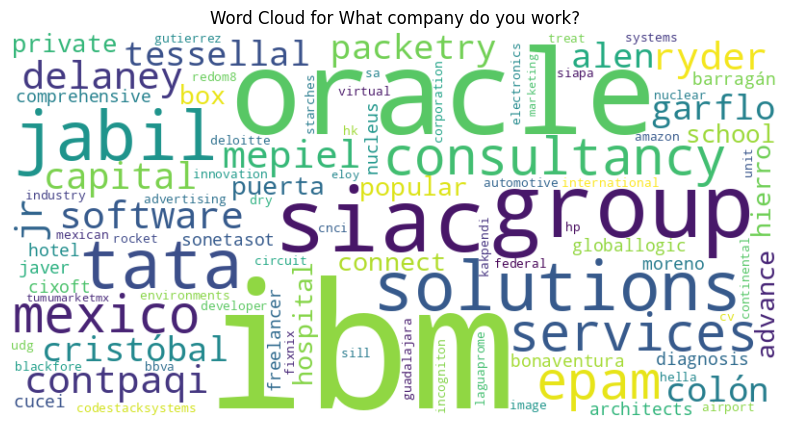

Most important 1-word combinations for What company do you work?: [(('ibm',), 11), (('oracle',), 4), (('siac',), 2)]
Most important 2-word combinations for What company do you work?: [(('tata', 'consultancy'), 2), (('consultancy', 'services'), 2), (('siac', 'software'), 1)]
Most important 3-word combinations for What company do you work?: [(('tata', 'consultancy', 'services'), 2), (('siac', 'software', 'siac'), 1), (('software', 'siac', 'ibm'), 1)]


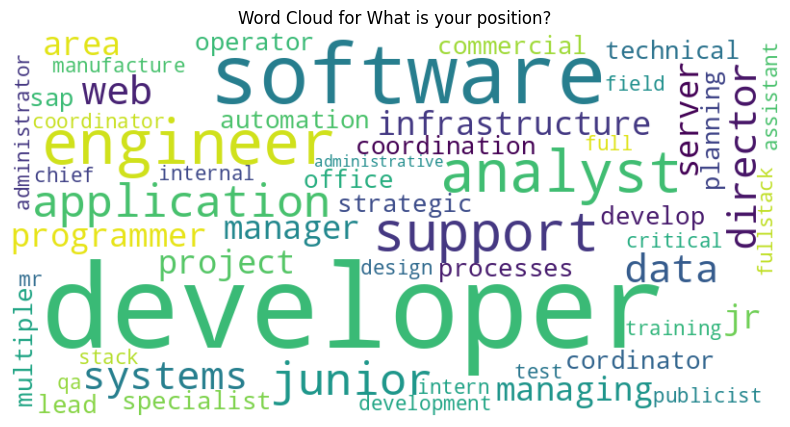

Most important 1-word combinations for What is your position?: [(('developer',), 38), (('software',), 16), (('engineer',), 8)]
Most important 2-word combinations for What is your position?: [(('software', 'developer'), 12), (('developer', 'software'), 8), (('developer', 'developer'), 8)]
Most important 3-word combinations for What is your position?: [(('developer', 'software', 'developer'), 6), (('software', 'developer', 'software'), 5), (('software', 'developer', 'developer'), 3)]


In [13]:
nlp_analysis = WordCloudGenerator(df, ["What company do you work?",	"What is your position?"])
nlp_analysis.run()

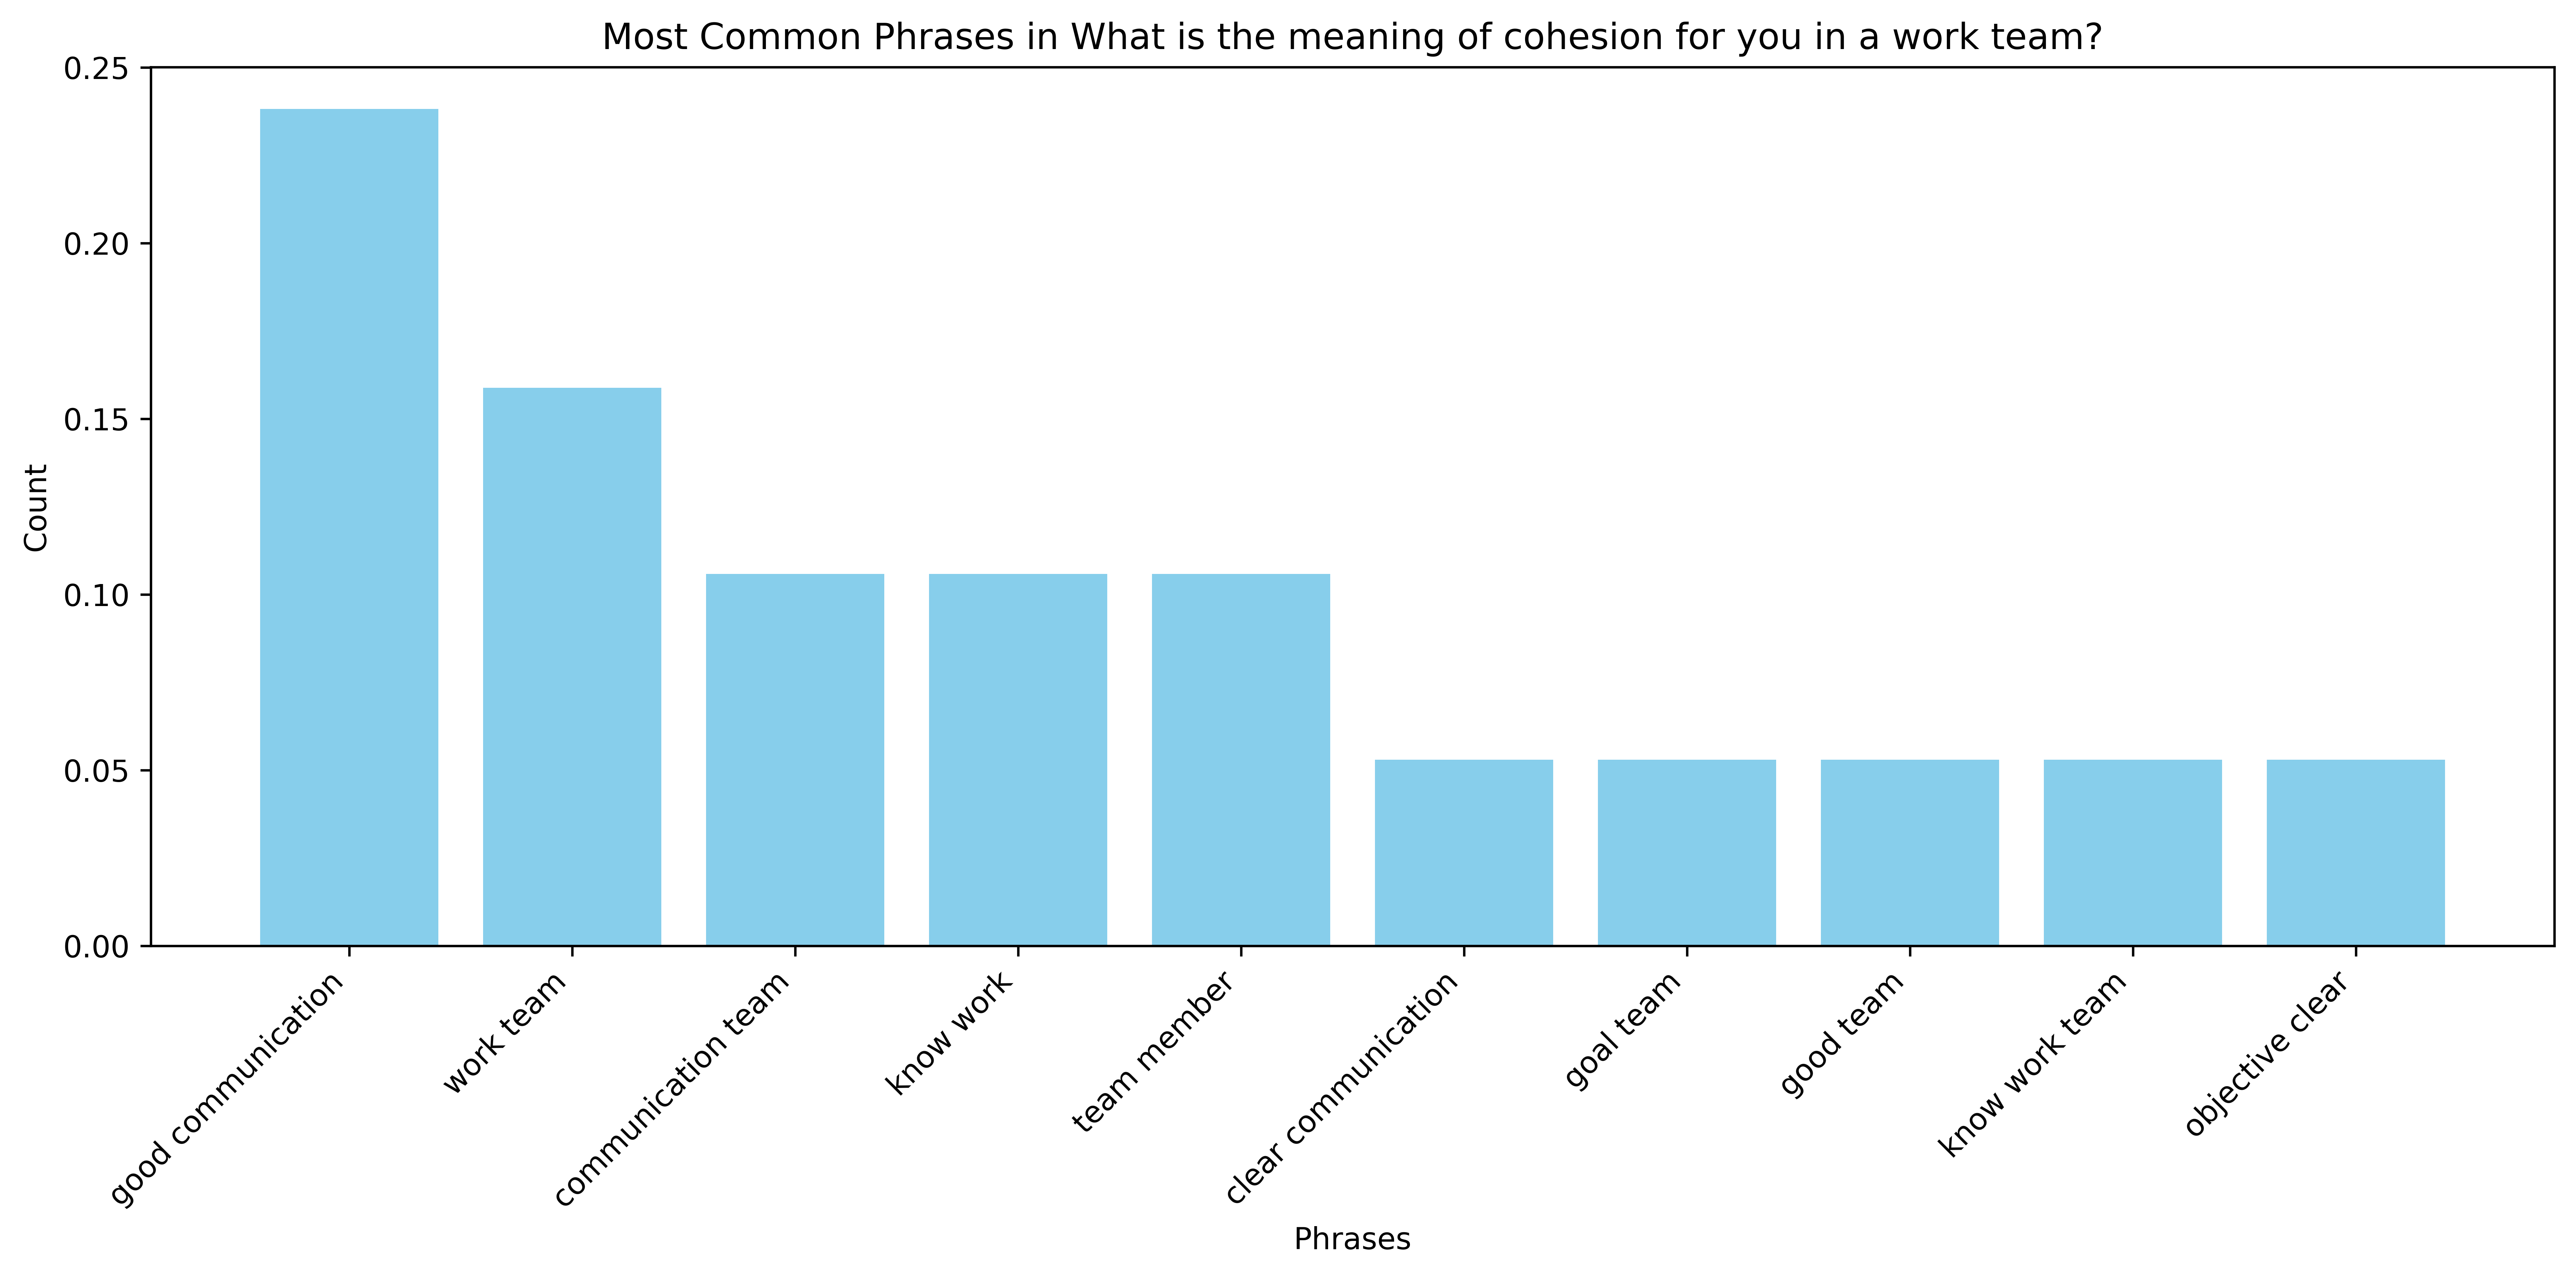

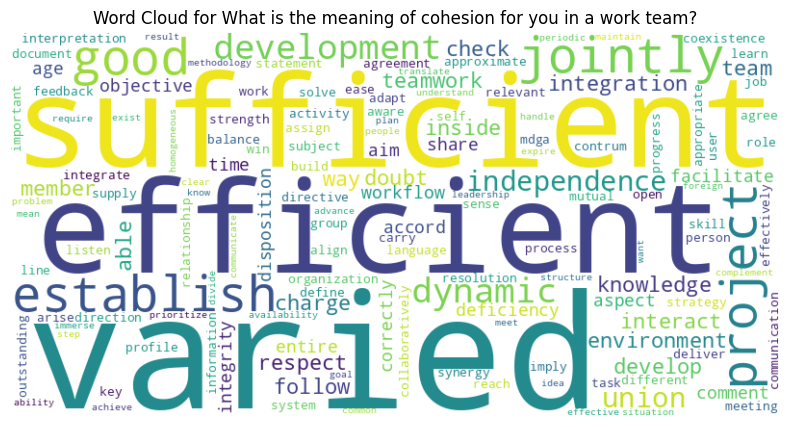

Most important 1-word combinations for What is the meaning of cohesion for you in a work team?: ["( ' team ' , ) 23", "( ' communication ' , ) 19", "( ' work ' , ) 22"]
Most important 2-word combinations for What is the meaning of cohesion for you in a work team?: ["( ' know ' , ' work ' ) 4", "( ' work ' , ' team ' ) 6", "( ' good ' , ' communication ' ) 9"]
Most important 3-word combinations for What is the meaning of cohesion for you in a work team?: ["( ' ' , ' sense ' , ' win ' ) 1", "( ' know ' , ' work ' , ' team ' ) 2", "( ' sense ' , ' win ' , ' understand ' ) 1"]
Not enough samples or features for word embedding in What is the meaning of cohesion for you in a work team?


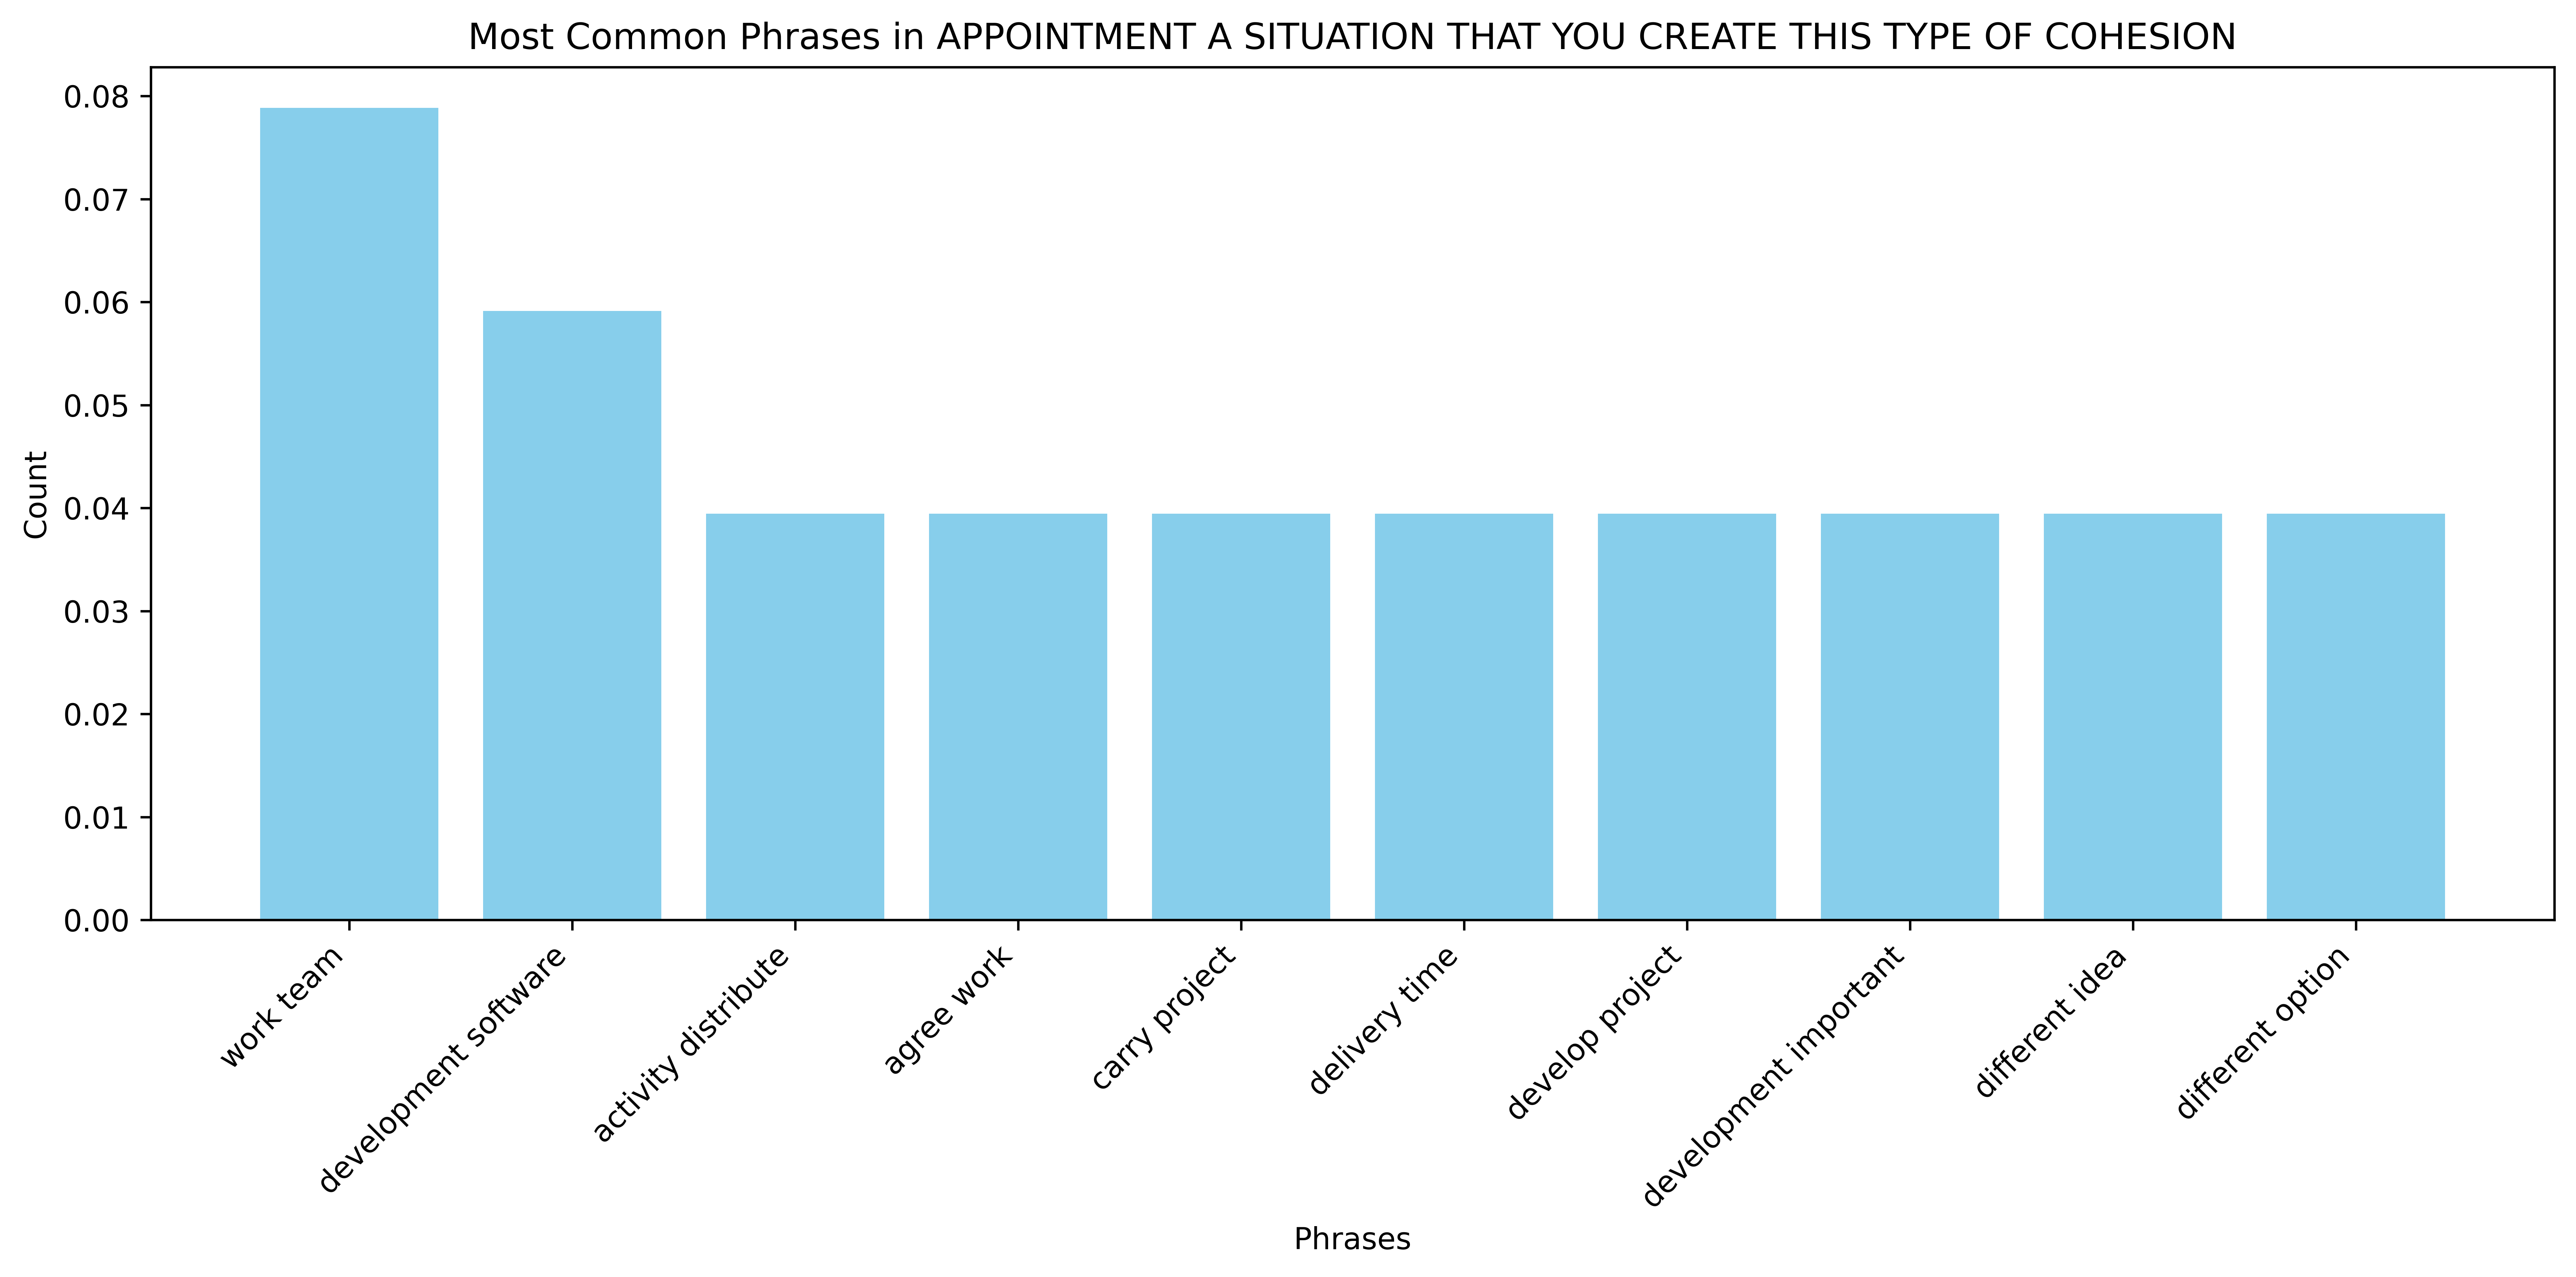

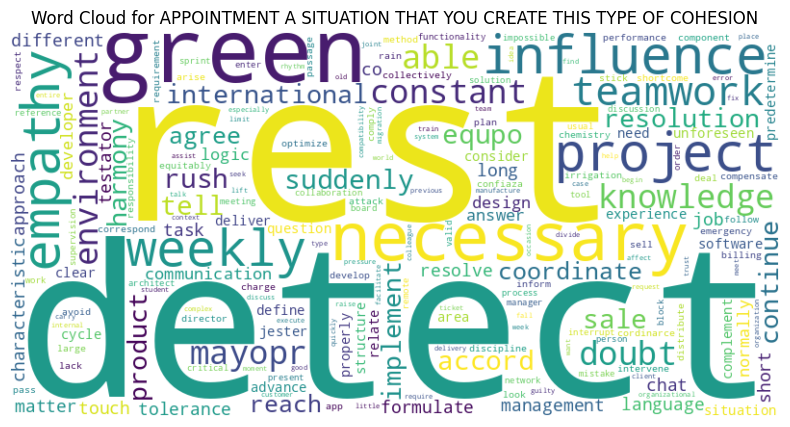

Most important 1-word combinations for APPOINTMENT A SITUATION THAT YOU CREATE THIS TYPE OF COHESION: ["( ' team ' , ) 15", "( ' work ' , ) 26", "( ' project ' , ) 19"]
Most important 2-word combinations for APPOINTMENT A SITUATION THAT YOU CREATE THIS TYPE OF COHESION: ["( ' solve ' , ' bug ' ) 2", "( ' work ' , ' team ' ) 4", "( ' development ' , ' software ' ) 3"]
Most important 3-word combinations for APPOINTMENT A SITUATION THAT YOU CREATE THIS TYPE OF COHESION: ["( ' bug ' , ' work ' , ' team ' ) 1", "( ' develop ' , ' solve ' , ' bug ' ) 1", "( ' solve ' , ' bug ' , ' work ' ) 1"]
Not enough samples or features for word embedding in APPOINTMENT A SITUATION THAT YOU CREATE THIS TYPE OF COHESION


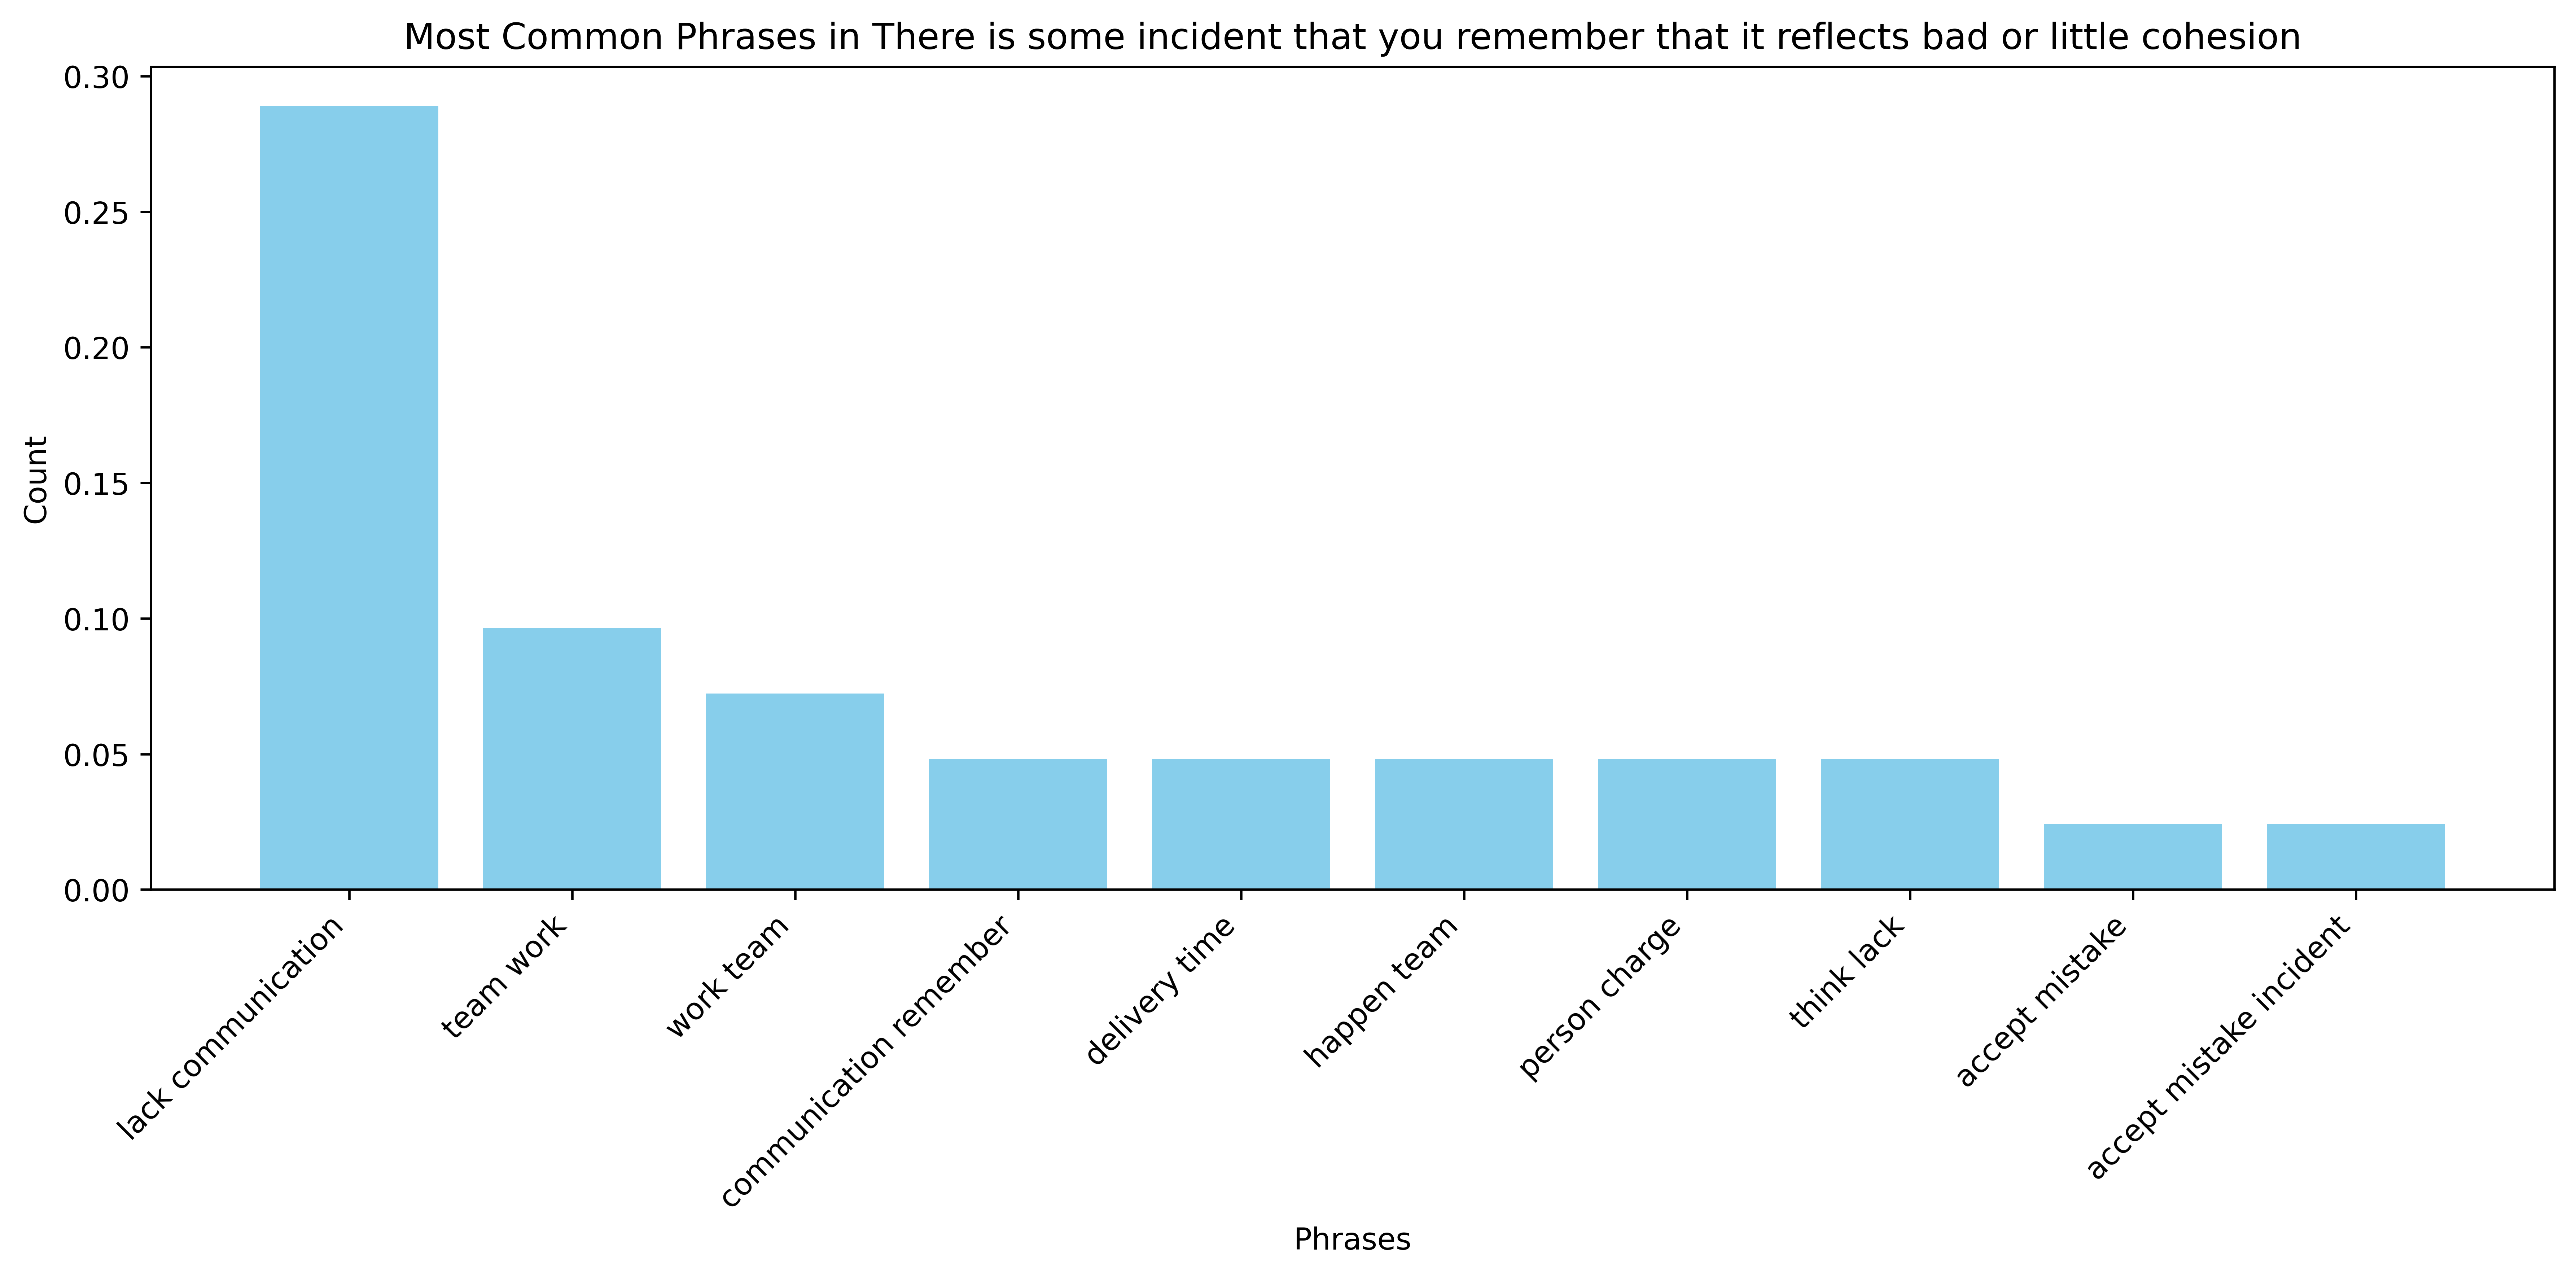

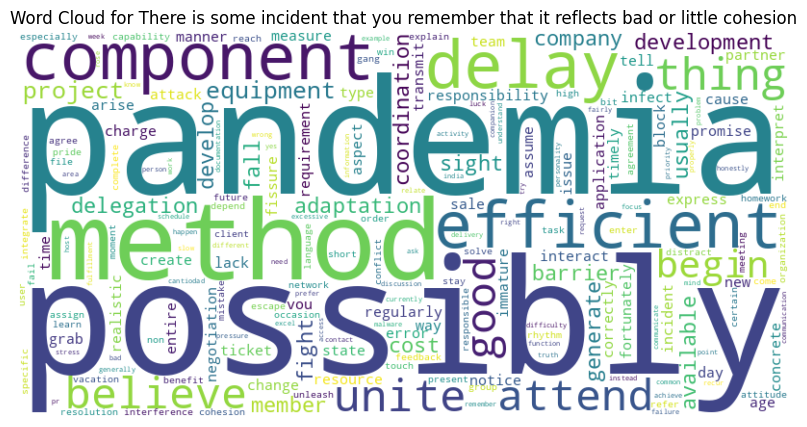

Most important 1-word combinations for There is some incident that you remember that it reflects bad or little cohesion: ["( ' lack ' , ) 15", "( ' communication ' , ) 16", "( ' work ' , ) 13"]
Most important 2-word combinations for There is some incident that you remember that it reflects bad or little cohesion: ["( ' team ' , ' work ' ) 4", "( ' work ' , ' team ' ) 3", "( ' lack ' , ' communication ' ) 12"]
Most important 3-word combinations for There is some incident that you remember that it reflects bad or little cohesion: ["( ' communication ' , ' resolution ' , ' request ' ) 1", "( ' resolution ' , ' request ' , ' want ' ) 1", "( ' work ' , ' team ' , ' work ' ) 2"]
Not enough samples or features for word embedding in There is some incident that you remember that it reflects bad or little cohesion


In [14]:
column_names = df.columns[-3:].tolist()
nlp_analysis = NLPAnalysis(df, column_names)
nlp_analysis.run()

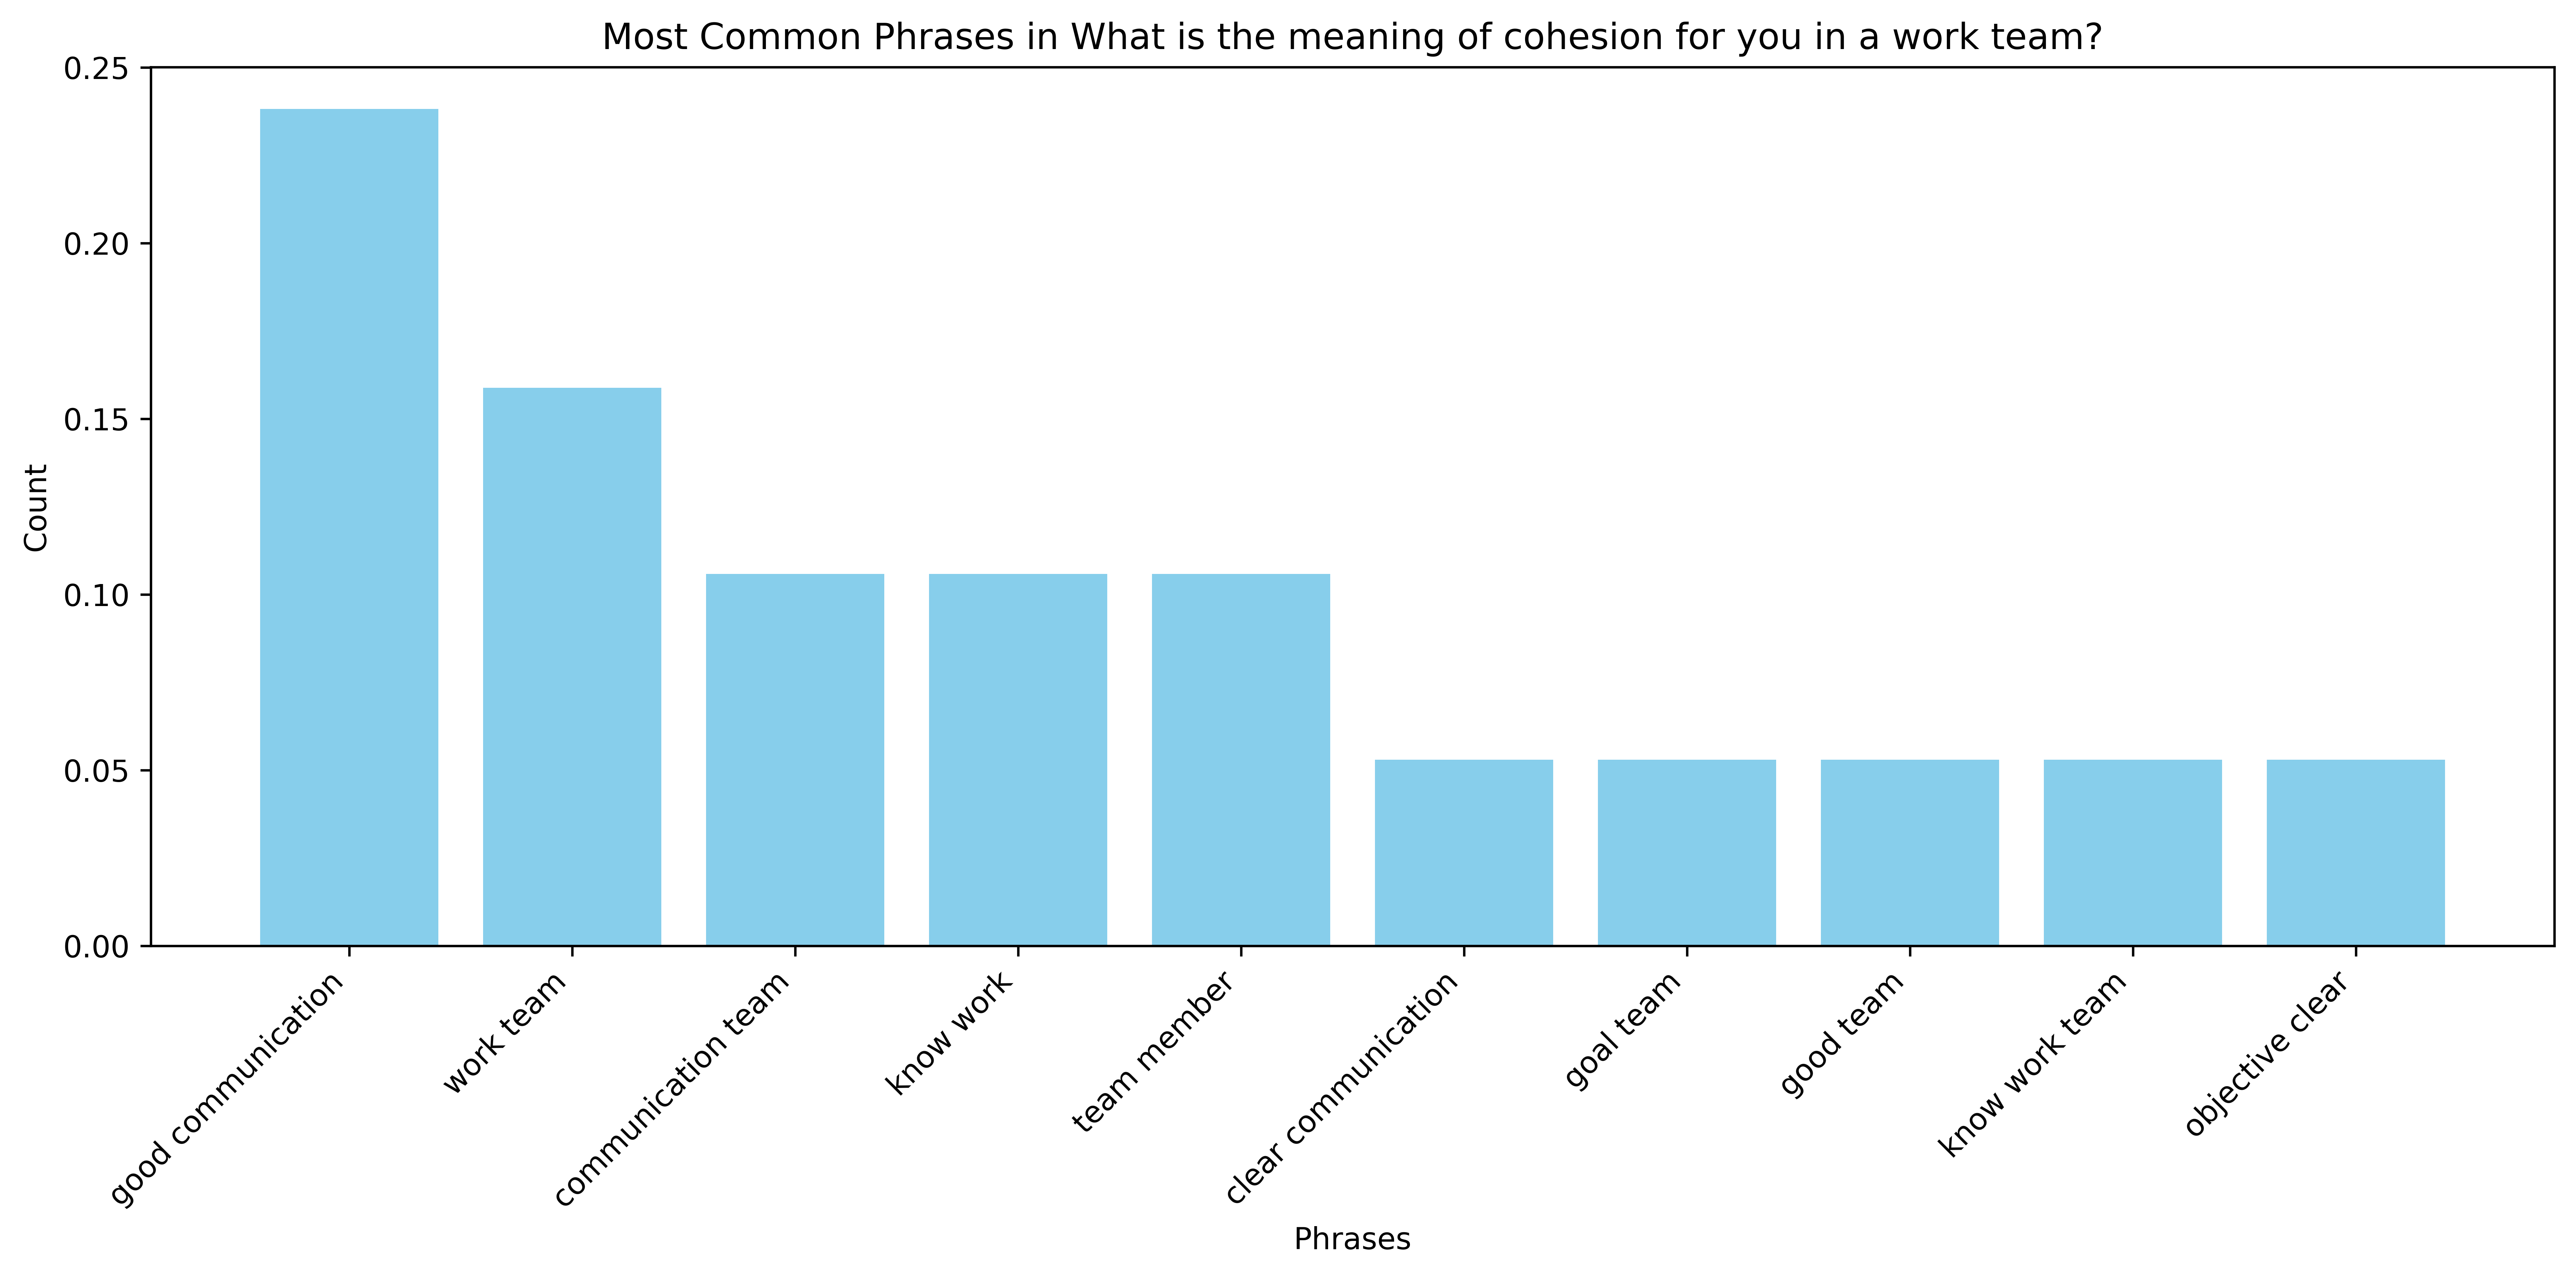

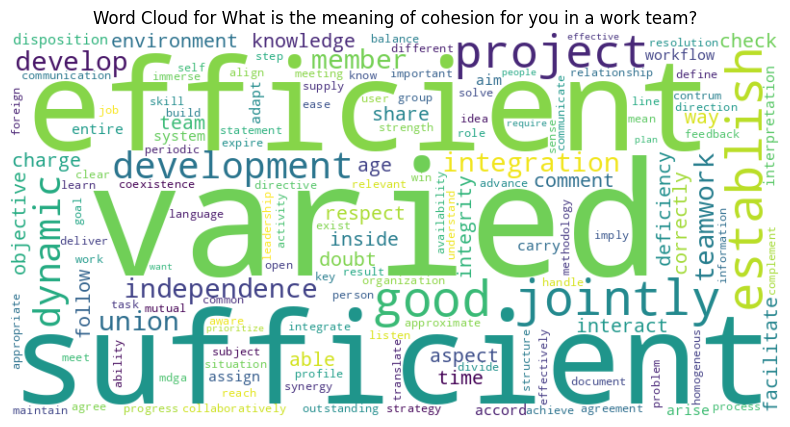

Most important 1-word combinations for What is the meaning of cohesion for you in a work team?: ["( ' team ' , ) 23", "( ' communication ' , ) 19", "( ' work ' , ) 22"]
Most important 2-word combinations for What is the meaning of cohesion for you in a work team?: ["( ' know ' , ' work ' ) 4", "( ' work ' , ' team ' ) 6", "( ' good ' , ' communication ' ) 9"]
Most important 3-word combinations for What is the meaning of cohesion for you in a work team?: ["( ' ' , ' sense ' , ' win ' ) 1", "( ' know ' , ' work ' , ' team ' ) 2", "( ' sense ' , ' win ' , ' understand ' ) 1"]
Not enough samples or features for word embedding in What is the meaning of cohesion for you in a work team?


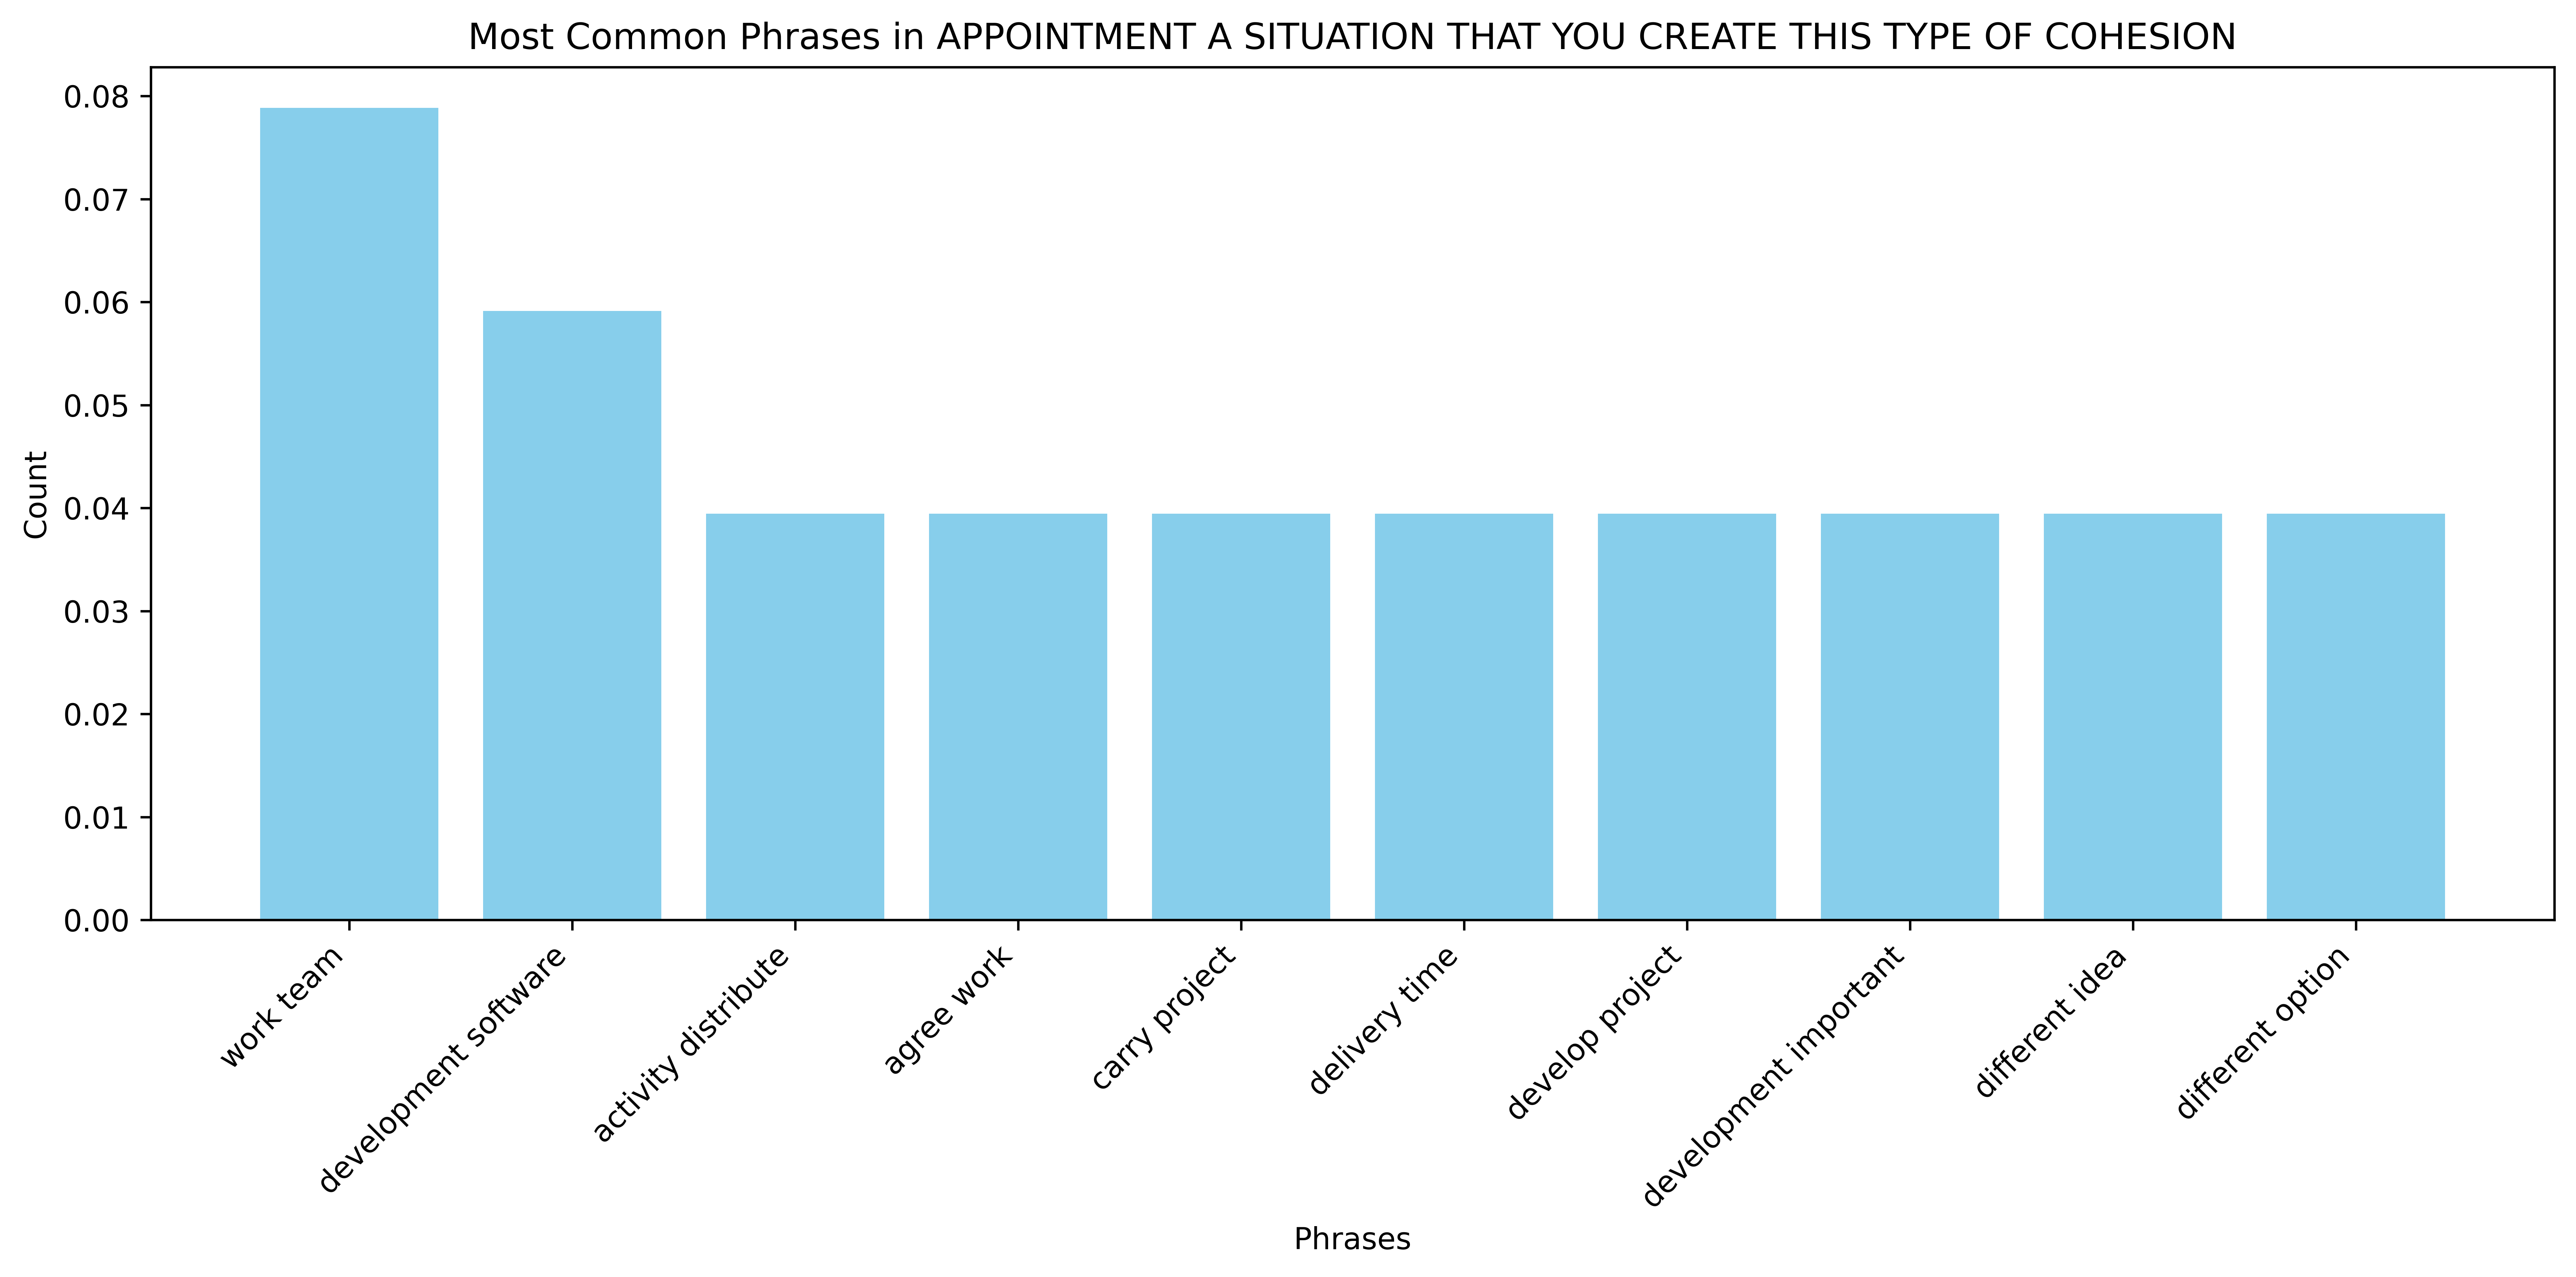

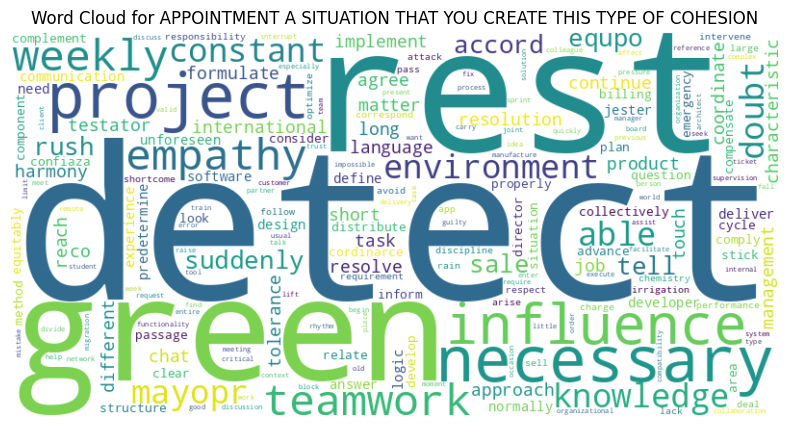

Most important 1-word combinations for APPOINTMENT A SITUATION THAT YOU CREATE THIS TYPE OF COHESION: ["( ' team ' , ) 15", "( ' work ' , ) 26", "( ' project ' , ) 19"]
Most important 2-word combinations for APPOINTMENT A SITUATION THAT YOU CREATE THIS TYPE OF COHESION: ["( ' solve ' , ' bug ' ) 2", "( ' work ' , ' team ' ) 4", "( ' development ' , ' software ' ) 3"]
Most important 3-word combinations for APPOINTMENT A SITUATION THAT YOU CREATE THIS TYPE OF COHESION: ["( ' bug ' , ' work ' , ' team ' ) 1", "( ' develop ' , ' solve ' , ' bug ' ) 1", "( ' solve ' , ' bug ' , ' work ' ) 1"]
Not enough samples or features for word embedding in APPOINTMENT A SITUATION THAT YOU CREATE THIS TYPE OF COHESION


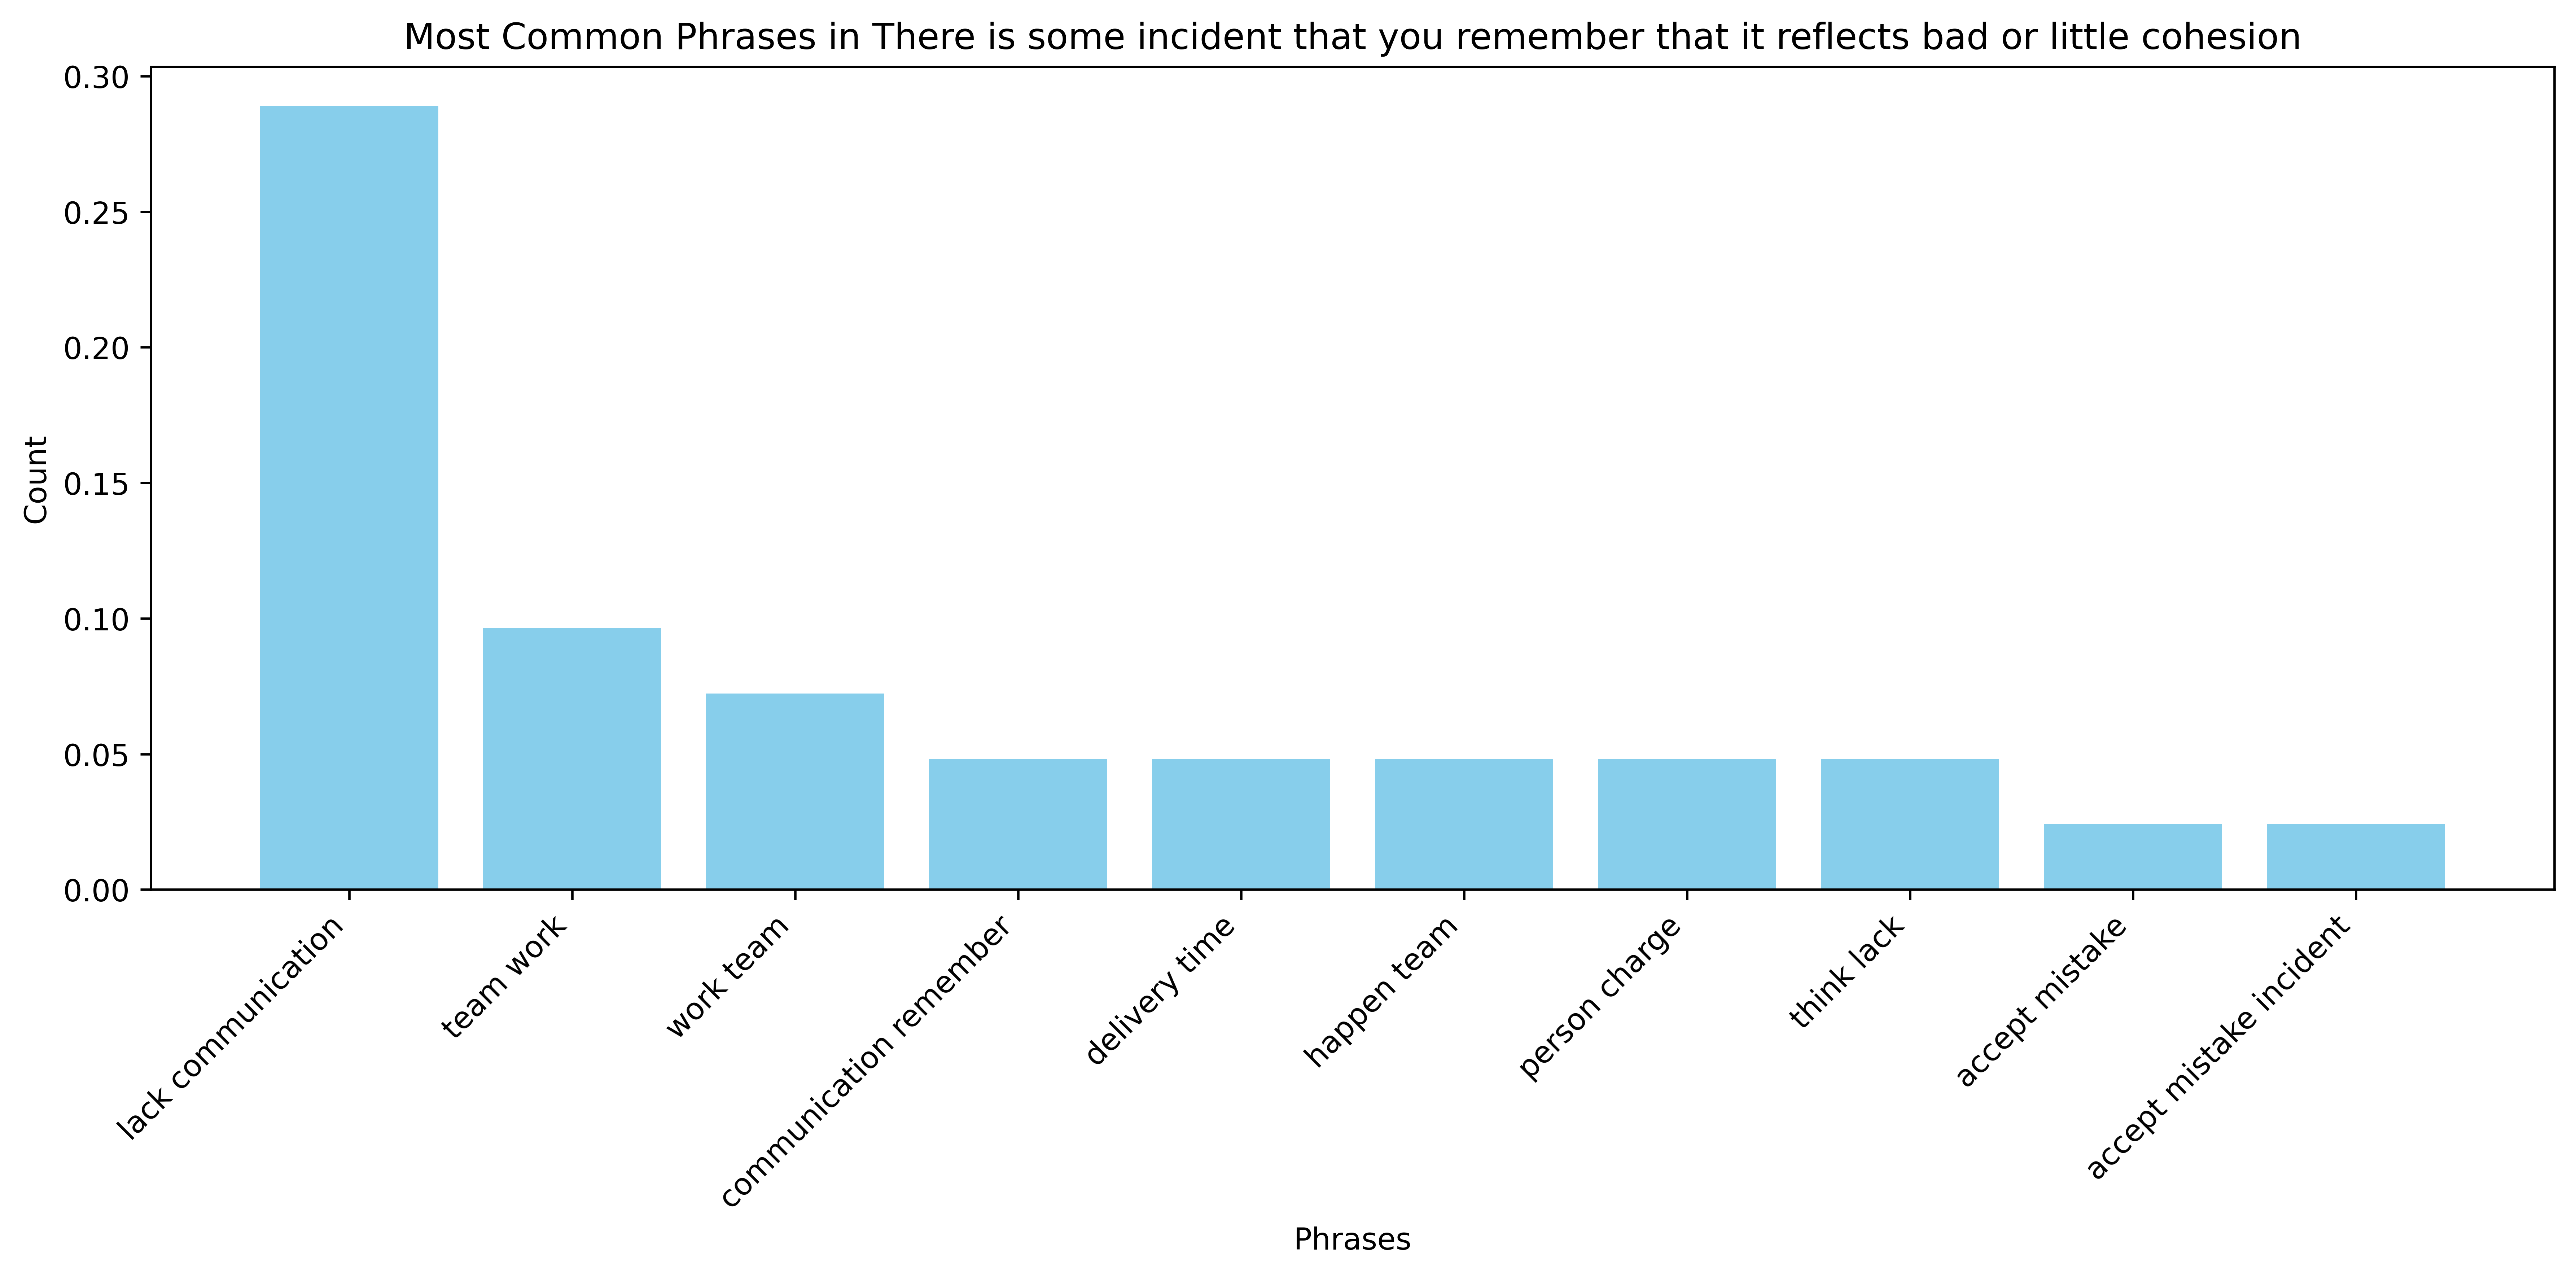

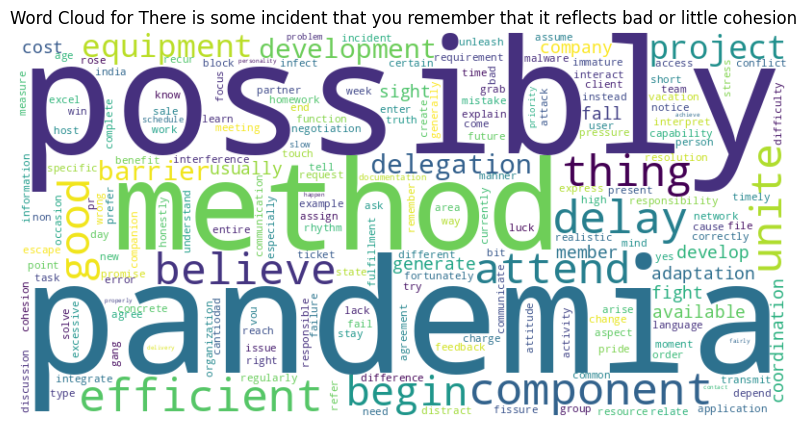

Most important 1-word combinations for There is some incident that you remember that it reflects bad or little cohesion: ["( ' lack ' , ) 15", "( ' communication ' , ) 16", "( ' work ' , ) 13"]
Most important 2-word combinations for There is some incident that you remember that it reflects bad or little cohesion: ["( ' team ' , ' work ' ) 4", "( ' work ' , ' team ' ) 3", "( ' lack ' , ' communication ' ) 12"]
Most important 3-word combinations for There is some incident that you remember that it reflects bad or little cohesion: ["( ' communication ' , ' resolution ' , ' request ' ) 1", "( ' resolution ' , ' request ' , ' want ' ) 1", "( ' work ' , ' team ' , ' work ' ) 2"]
Not enough samples or features for word embedding in There is some incident that you remember that it reflects bad or little cohesion


In [15]:
column_names = df.columns[-3:].tolist()
nlp_analysis = NLPAnalysis(df, column_names, remove_sentiment_stop_words=True)
nlp_analysis.run()

In [1]:
import pandas as pd
import docx
import re

# Function to read text from a .docx file
def read_docx(file_path):
    doc = docx.Document(file_path)
    full_text = []
    for para in doc.paragraphs:
        full_text.append(para.text)
    return '\n'.join(full_text)

# Function to convert experience text to number of years
def convert_experience_to_years(experience_text):
    if 'año' in experience_text:
        years = re.search(r'(\d+)\s*año', experience_text)
        if years:
            return int(years.group(1))
    if 'mes' in experience_text:
        months = re.search(r'(\d+)\s*mes', experience_text)
        if months:
            return round(int(months.group(1)) / 12, 2)
    return 'N/A'

# Read the text from the .docx file
file_path = '/home/nacho/Documents/repos/servicio_social_inco_udg/respuestas_d.docx'
text = read_docx(file_path)

# Split the text into lines
lines = text.strip().split('\n')

# Initialize lists to store the data
profesionistas = []
experiencias = []
factores = []

# Iterate over the lines and extract the data
i = 0
while i < len(lines):
    if lines[i].startswith("Profesionista"):
        profesionistas.append(lines[i].split(':')[0].strip())
        experiencia_text = lines[i].split(':')[1].strip()
        experiencias.append(convert_experience_to_years(experiencia_text))
        factor = []
        i += 1
        while i < len(lines) and not lines[i].startswith("Profesionista"):
            factor.append(lines[i].strip())
            i += 1
        factores.append(' '.join(factor))
    else:
        i += 1

# Create a DataFrame from the lists
df = pd.DataFrame({
    'Profesionista': profesionistas,
    'Experiencia (años)': experiencias,
    'Factores': factores
})

# Save the DataFrame to a CSV file
df.to_csv('output.csv', index=False)

In [2]:
df

Profesionista Experiencia (años)  \
0    Profesionista 1                  2   
1    Profesionista 2                  3   
2    Profesionista 3                  5   
3    Profesionista 4                  3   
4    Profesionista 5                N/A   
..               ...                ...   
56  Profesionista 57               0.17   
57  Profesionista 58                  6   
58  Profesionista 59                  3   
59  Profesionista 60                  6   
60  Profesionista 61                 10   

                                             Factores  
0   Los factores que considero pueden ser la comun...  
1   Creo que sería de nuevo la comunicación, la co...  
2   Buena comunicación, tener siempre mente abiert...  
3   Organización, responsabilidad por parte de tod...  
4   Comunicación, también organizar los horarios b...  
..                                                ...  
56  Pues yo pienso que lo más importante es litera...  
57  Primeramente, el tiempo fuera de trabajos debe...  
58  Pues creo que sería buena comunicación y un bu...  
59  Principalmente yo creo que comunicación, la me...  
60  Mucha comunicación y mucha claridad, a veces s...  

[61 rows x 3 columns]

In [3]:
from deep_translator import GoogleTranslator
import pandas as pd

# Translate column names
translated_columns = [GoogleTranslator(source='es', target='en').translate(col) for col in df.columns]
df.columns = translated_columns

# Translate cell values, skipping None or NaN values
for column in df.columns:
    df[column] = df[column].apply(lambda x: GoogleTranslator(source='es', target='en').translate(str(x)) if pd.notnull(x) else x)


In [4]:
df 

Professional Experience (years)  \
0    Professional 1                  2   
1    Professional 2                  3   
2    Professional 3                  5   
3    Professional 4                  3   
4    Professional 5                N/A   
..              ...                ...   
56  Professional 57               0.17   
57  Professional 58                  6   
58  Professional 59                  3   
59  Professional 60                  6   
60  Professional 61                 10   

                                              Factors  
0   The factors that I consider can be communicati...  
1   I think it would be the communication, trust a...  
2   Good communication, always have an open mind a...  
3   Organization, responsibility on the part of al...  
4   Communication, also organize the schedules wel...  
..                                                ...  
56  Well, I think that the most important thing is...  
57  First, the time out of work must also support ...  
58  Well, I think it would be good communication a...  
59  Mainly I believe that communication, the impro...  
60  A lot of communication and a lot of clarity, s...  

[61 rows x 3 columns]

In [ ]:
from transformers import pipeline
import pandas as pd
import random

# Initialize the summarization pipeline
summarizer = pipeline("summarization", model="facebook/bart-large-cnn", device="cpu")

def dynamic_lengths(input_length, min_ratio=0.3, max_ratio=0.6, min_cap=5, max_cap=50):
    """
    Dynamically calculate min and max lengths based on input length.
    """
    max_length = min(max_cap, max(min_cap, int(input_length * max_ratio)))
    min_length = min(max_length - 1, max(min_cap, int(input_length * min_ratio)))
    if min_length >= max_length:
        min_length = max_length - 1
    return min_length, max_length

def calculate_dynamic_batch_size(text_list, base_size=10):
    """
    Dynamically calculate batch size based on the size of the input.
    """
    total_length = sum(len(text.split()) for text in text_list)
    avg_length = total_length // len(text_list) if text_list else base_size
    return max(base_size, avg_length // 50)  # Adjust divisor as needed for batch size scaling

def randomize_batches(text_list, batch_size):
    """
    Randomly shuffle and organize text into batches.
    """
    random.shuffle(text_list)
    return [' '.join(text_list[i:i+batch_size]) for i in range(0, len(text_list), batch_size)]

def batch_summarize(text_batches):
    """
    Summarize each batch of text.
    """
    batch_summaries = []
    for batch in text_batches:
        input_length = len(batch.split())
        min_length, max_length = dynamic_lengths(input_length)
        summary = summarizer(batch, max_length=max_length, min_length=min_length, do_sample=False)
        batch_summaries.append(summary[0]['summary_text'])
    return batch_summaries

def summarize_factors_column(df, column):
    """
    Summarize the 'Factors' column with randomized batches.
    """
    all_answers = df[column].dropna().astype(str).tolist()
    batch_size = calculate_dynamic_batch_size(all_answers)
    text_batches = randomize_batches(all_answers, batch_size)
    batch_summaries = batch_summarize(text_batches)
    return ' '.join(batch_summaries)

# Example usage
# Assuming `df` is your DataFrame and 'Factors' is the column to summarize
final_summary = summarize_factors_column(df, 'Factors')

# Save the summary to a file
with open("factors_summary_4.txt", "w") as file:
    file.write(final_summary)

# Display the summary
print(final_summary)

Device set to use cpu


Communication is the first, good leadership, an understanding of the problem and knowing what to do. Mainly good communication, have empathy and be open to different points of view. The coexistence zone more than anything outside the work area I think that the most important thing is that everyone knows what they are doing, what we are working on, how difficult or easy, and that everyone understands how our work works. Well, there is clarity in communication, that there are Mainly communication, not only labor, but also there is a slightly more personal relationship between team members since this does not see them simply as your coworkers, but you really want to help them. Mainly trust, responsibility and commitment. Mainly communication, I think it is very important that this part does not miss, because without communication no one is going to find out what each one does in each team. Communication, also organize the schedules well and the description of your Communication, disciplin

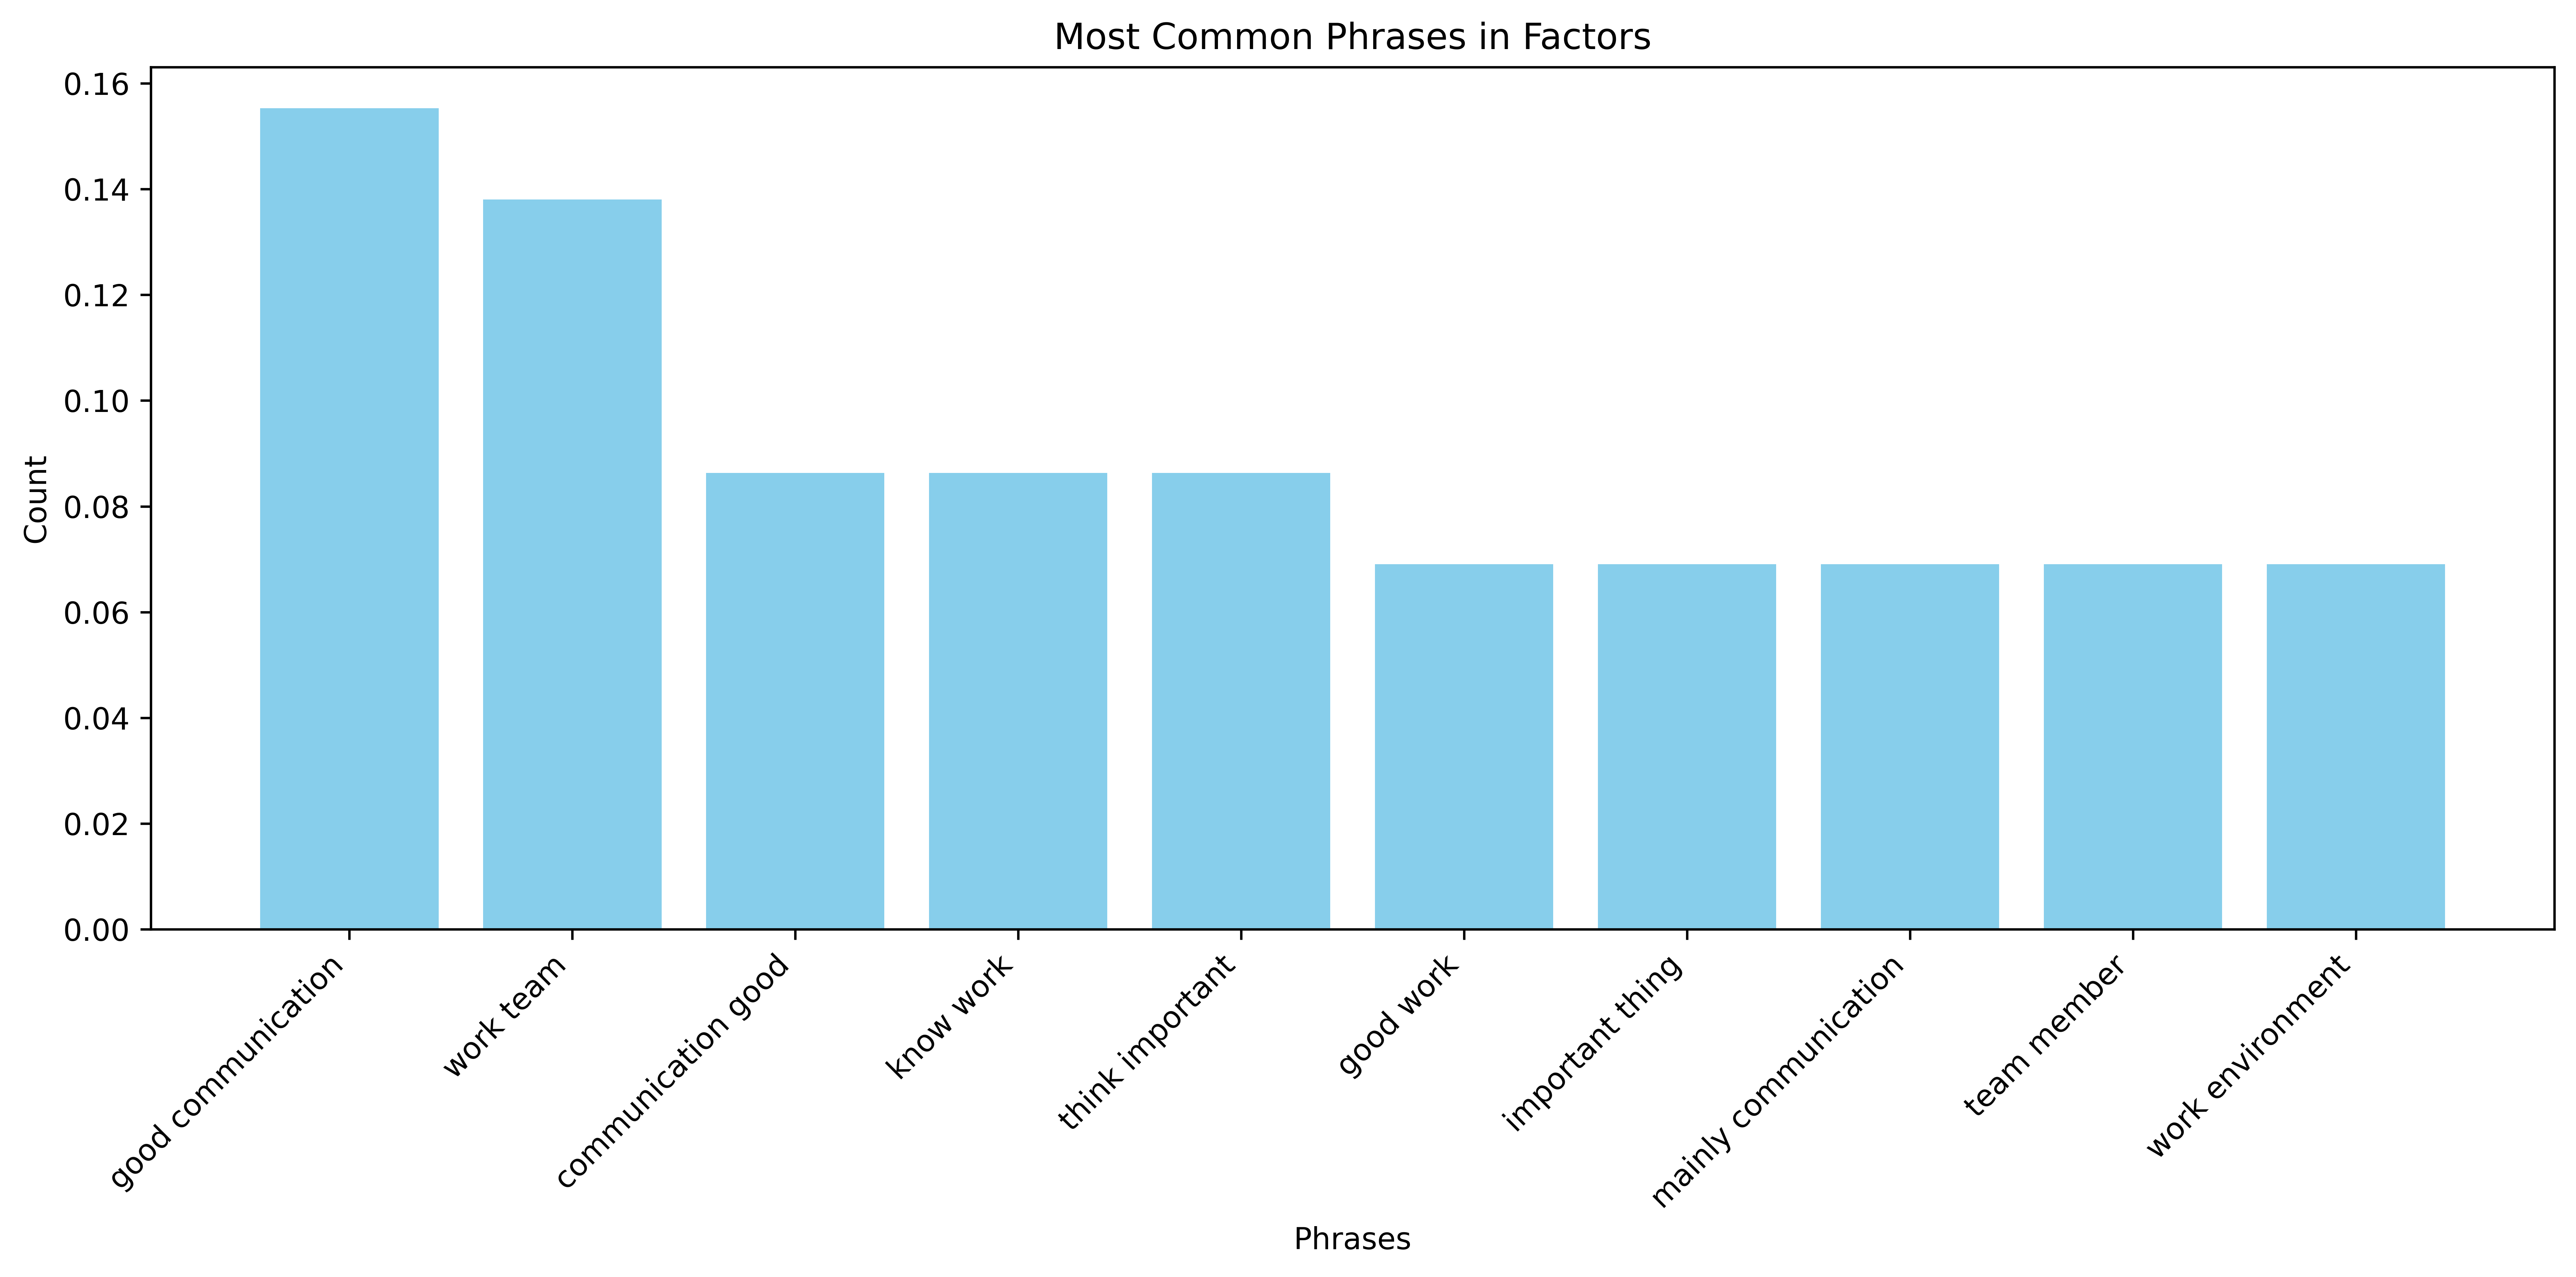

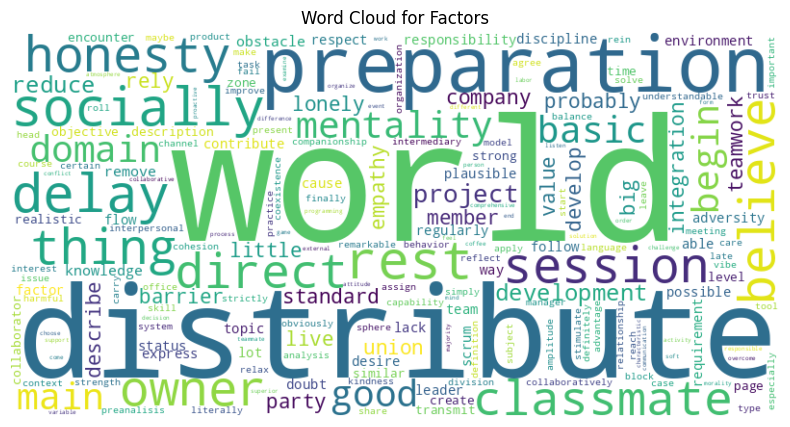

Most important 1-word combinations for Factors: ["( ' communication ' , ) 38", "( ' good ' , ) 30", "( ' work ' , ) 40"]
Most important 2-word combinations for Factors: ["( ' work ' , ' team ' ) 8", "( ' communication ' , ' good ' ) 5", "( ' good ' , ' communication ' ) 9"]
Most important 3-word combinations for Factors: ["( ' know ' , ' work ' , ' team ' ) 3", "( ' good ' , ' work ' , ' environment ' ) 3", "( ' good ' , ' communication ' , ' good ' ) 3"]
Not enough samples or features for word embedding in Factors


In [21]:
column_names = ['Factors']
nlp_analysis = NLPAnalysis(df, column_names)
nlp_analysis.run()